
By Ciarán McMenamin


# $$Introduction$$
A momentum trading strategy is a way of deciding which stocks to buy/sell by the derection the market seems to be going; the most simple of which is buy if the price is rising and sell if it is falling. This assumes that the market tends to keep going in the same direction in the short term. We are going to explore a variation of this strategy and backtest it against historical data using past S&P 500 stocks.

The basis of our strategy is identical to that of the momentum strategy, however we add in a spike variable to stop us betting on unsustainable positions. This spike percentage, which we denote as $dw$, warns us that there is a shock in the market and we shouldn't follow the direction the price is going in - in fact we should do the opposite betting that the price will bounce back to a more realistic position.

Then we will explore what makes the strategy most effective.
~
We will start by defining our functions to execute the trades (weekly) then analyse the effectiveness on a single stock e.g Apple. Then we will try add more stocks and maybe more frequency (daily).
\
The trading strategy follows:

* If any given stock rises by dx in a week we will buy that stock
* If any given stock falls by dx in a week we will sell that stock
* If neither we do nothing

Later we will try add in stop profit/loss and also maybe fractional/multiple purchases.


We will say:
* dx = % to indicate buy/sell
* dy = % to indicate take profit
* dz = % to indicate stop loss
* dw = % to incicate spike


Which we can change to determine the "best" strategy (in hindsight of course).

In [151]:
dx = 0.03
dy = 0.2
dz = 0.2
dw = 0.1
start = '2020-01-01'
end = '2025-01-01'

## Installing data

In [85]:
!pip install yfinance --quiet
import pandas as pd
import yfinance as yf
import numpy as np
import random
import matplotlib.pyplot as plt
%pprint

Pretty printing has been turned OFF


# $$Building\ the\ function$$

## Singal Function

We want a function that will take a current stock price $S_t$ and a historic stock price $S_{t-1}$ and indicate what we should do with it. We are going to be making a simple model, i.e time points are taken as the open of each week. Then we will explore the open of each day.

In [86]:
def signal(x1, x2, dx, dw):   # x1 is any historic price and x2 is the current price
    pchange=(x2 - x1)/x1
    if pchange >= dx and pchange <= dw:
        return 1 # buy from dx
    elif pchange <= - dx and pchange > - dw:
        return -1 # sell from dx
    elif pchange >= dw:
        return -1 # buy from dw
    elif pchange < -dw:
        return 1 # sell form dw
    else:
        return 0 # hold
        

## Weekly Prices Download

A simple function that gives a list of prices (for the open of each week) given a ticker between two dates.

In [87]:
def W_download_data(ticker, start_date, end_date):
    prices_data = yf.download(ticker, start_date, end_date, progress=False, auto_adjust=True) # download the data
    prices_weekly = prices_data['Open'].resample('W').last()  # interpret weekly open prices
    prices_list = [round(price, 2) for price in prices_weekly[ticker].tolist()]
    return prices_list
    

In [88]:
# Test
AAPL_prices = W_download_data('AAPL', '2023-01-01', '2024-01-01')

In [89]:
# Test
AAPL_prices

[124.4, 130.34, 133.55, 141.33, 146.14, 147.77, 150.63, 145.45, 146.37, 148.52, 154.32, 157.07, 160.61, 160.6, 162.73, 163.19, 166.59, 169.05, 171.9, 174.64, 171.6, 179.24, 179.7, 184.88, 183.71, 189.73, 189.51, 188.34, 192.18, 192.74, 183.68, 175.8, 170.82, 175.86, 187.86, 176.82, 174.97, 173.17, 170.54, 172.31, 179.86, 173.81, 165.48, 172.75, 182.63, 188.87, 189.48, 188.95, 192.79, 196.09, 193.76, 192.49]

Now we have the weekly prices for the AAPL stock in a list we can define more functions which incorporate the list.

## Buy/Sell indication list

This function simply tells us at what index the signal tells us to long or short.

In [90]:
# Getting our actions in a list
def actionlist(stock_price_list, dx, dw):
    actions_list=[0] # fill with zeros
    for i in range(1, len(stock_price_list)):
        bs_actions = signal(stock_price_list[i-1], stock_price_list[i], dx, dw)  #bs_actions = buy/sell actions
        actions_list.append(bs_actions)
    return  actions_list



In [91]:
# Test
start = '2023-01-01'
end = '2024-01-01'
AAPL_prices_list = W_download_data('AAPL', start, end)
print(actionlist(AAPL_prices_list, dx ,dw))
AAPL_actions_list = actionlist(AAPL_prices_list, dx, dw)
print('List length = ' + str(len(AAPL_actions_list)))

[0, 1, 0, 1, 1, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, -1, -1, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
List length = 52


## Take Profit/Stop loss
We now want a take profit and stop loss funtion. We will say when we have gained $dy$% or lose $dz$% we will close that position. 

First let's visualise it better.

In [92]:
def check_actions(actions_list, prices_list):   # Puts our actions list in a comprehendable list
    results = []
    for _ in range(len(actions_list)-1):
        if actions_list[_] == 1:
            results.append(f'Buy at {prices_list[_]}')
        elif actions_list[_] == -1:
            results.append(f'Sell at {prices_list[_]}')
        else:
            results.append(f'No action at {prices_list[_]}')
    return results


In [93]:
# Test
AAPL_results_list = check_actions(AAPL_actions_list, AAPL_prices_list)
print(AAPL_results_list)
print(len(AAPL_results_list))

['No action at 124.4', 'Buy at 130.34', 'No action at 133.55', 'Buy at 141.33', 'Buy at 146.14', 'No action at 147.77', 'No action at 150.63', 'Sell at 145.45', 'No action at 146.37', 'No action at 148.52', 'Buy at 154.32', 'No action at 157.07', 'No action at 160.61', 'No action at 160.6', 'No action at 162.73', 'No action at 163.19', 'No action at 166.59', 'No action at 169.05', 'No action at 171.9', 'No action at 174.64', 'No action at 171.6', 'Buy at 179.24', 'No action at 179.7', 'No action at 184.88', 'No action at 183.71', 'Buy at 189.73', 'No action at 189.51', 'No action at 188.34', 'No action at 192.18', 'No action at 192.74', 'Sell at 183.68', 'Sell at 175.8', 'No action at 170.82', 'No action at 175.86', 'Buy at 187.86', 'Sell at 176.82', 'No action at 174.97', 'No action at 173.17', 'No action at 170.54', 'No action at 172.31', 'Buy at 179.86', 'Sell at 173.81', 'Sell at 165.48', 'Buy at 172.75', 'Buy at 182.63', 'Buy at 188.87', 'No action at 189.48', 'No action at 188.95

### Functions

In [94]:
def take_profit(entry_price, current_price, dy, position):  
    if position == 'long':  # bought
        target_price = entry_price * (1 + dy)   
        if current_price >= target_price:
            return True  
    elif position == 'short':  # sold
        target_price = entry_price * (1 - dy)
        if current_price <= target_price:
            return True  
    return False

def stop_loss(entry_price, current_price, dz, position):  
    if position == 'long':  # bought
        target_price = entry_price * (1 - dz)  
        if current_price <= target_price:
            return True  
    elif position == 'short':  # sold
        target_price = entry_price * (1 + dz) 
        if current_price >= target_price:
            return True  
    return False 


### Profit function

This function takes in two prices and then determines (given the stop/take percentages and postion) the profit when executed.
In our model we invest the same amount into each trade, this assumes we can buy fractions of stock, i.e buy 10 shares at £100 then close position at £120, then the gain is 20%, then the stock rises to £200 and we buy 5 shares so that each time the same value is put in - £1000.

In [95]:
def profits(x1, x2, dy, dz, position):        # calculates our profits as percentages
    if position == 'long':
        if take_profit(x1, x2, dy, 'long') == True:
            profit = 100*(x2 - x1)/x1
            return profit        
        elif stop_loss(x1, x2, dz, 'long') == True:    
            profit = 100*(x2 - x1)/x1
            return profit            
        else:
            return 0            
    elif position == 'short':
        if take_profit(x1, x2, dy, 'short') == True:
            profit = 100*(x1 - x2)/x1
            return profit
            
        elif stop_loss(x1, x2, dz, 'short') == True:
            profit = 100*(x1- x2)/x1
            return profit
        else:
            return 0
    else:
        return 0

## Total Profit

This function outputs the indexes of opening and closing a position with the respective profit.

In [96]:
def calculate_profits(ticker, start_date, end_date, dy, dz, dx, dw):
    # Using our functions from earlier
    prices_list = W_download_data(ticker, start_date, end_date)
    actions_list = actionlist(prices_list, dx, dw)    
    results_list = check_actions(actions_list, prices_list)
    # Empty lists
    profits_list = []
    action_points = []
    tpsl_points = []
    i = 0

    while i < len(results_list):
        action = results_list[i]
        
        action_type, entry_price_str = action.split(' at ') # Makes entry price a string but we want a floating value
        entry_price = float(entry_price_str)

        if action_type == 'Buy':
            position = 'long'
        elif action_type == 'Sell':
            position = 'short'
        else:
            i += 1
            continue  # Skip if 'No action'

        # Look ahead for when this trade should close
        for j in range(i + 1, len(results_list)):
            exit_price = prices_list[j]
            profit = profits(entry_price, exit_price, dy, dz, position)

            # Close trade if take-profit/stop-loss hit AND no immediate opposing signal
            if profit != 0:
                prev_price = prices_list[j-1] if j > 1 else exit_price
                sig = signal(prev_price, exit_price, dx, dw)
                # Prevent immediately opening a new position of the same type
                if not ((position == 'long' and sig == 1) or (position == 'short' and sig == -1)):
                    profits_list.append(profit)
                    action_points.append(i)
                    tpsl_points.append(j)
                    i = j  # Move i forward to avoid overlapping trades
                    break
        else:
            # If loop ends without breaking, no profit condition was met
            i += 1
            continue

          # Continue to next point after trade closure
        i += 1

    # If a closing position wasn't found (because of take profit/stop loss) in the time frame then we still want to know the last inication - buy/sell
    unmatched_position = tpsl_points[-1]
    last_close = len(results_list)
    # Very similar to above
    for _ in range(unmatched_position + 1, len(results_list)):
        action = results_list[_]
        
        action_type, entry_price_str = action.split(' at ')
        entry_price = float(entry_price_str)

        if action_type == 'Buy':
            position = 'long'
            action_points.append(_)
            tpsl_points.append(last_close)
            prof = 100* (prices_list[last_close] - prices_list[_])/prices_list[_]
            profits_list.append(prof)
            break 
            
        elif action_type == 'Sell':
            position = 'short'
            action_points.append(_)
            tpsl_points.append(last_close)
            prof = 100* (prices_list[_] - prices_list[last_close])/prices_list[_]
            profits_list.append(prof)
            break
        else:
            i += 1
            continue  # Skip if no action
  
    rounded_list = [round(x, 2) for x in profits_list]
    return rounded_list, action_points, tpsl_points


In [97]:
# Test
AAPL_prices_list = W_download_data('AAPL', '2020-01-01', end)
AAPL_profits_list, AAPL_action_points, AAPL_tpsl_points = calculate_profits('AAPL', '2020-01-01', end, dy, dz, dx, dw)
AAPL_actions_list = actionlist(AAPL_prices_list, dx, dw)
print(AAPL_profits_list)
print('Buy/Sell points:' + str(AAPL_action_points))
print('Take Profit/Stop Loss:' + str(AAPL_tpsl_points))


[-20.23, -26.22, 22.86, -26.42, 24.33, 22.68, 1.45]
Buy/Sell points:[1, 13, 20, 29, 33, 87, 182]
Take Profit/Stop Loss:[11, 18, 28, 32, 81, 180, 208]


In [98]:

def total_profit(x):
    totalprofit=sum(x)
    rounded = round(totalprofit, 2)
    return rounded

In [99]:
# Test
AAPL_profit = total_profit(AAPL_profits_list)
print(AAPL_profit)

-1.55


## One position 

In [100]:
def one_position_actions_list(actions_list, action_points):
    buy_sell_times=[]
    for j in range(len(actions_list)):
        if j in action_points:
            buy_sell_times.append(actions_list[j])
        else:
            buy_sell_times.append(0)

    return buy_sell_times

def one_position_tpsl_list(action_points, tpsl_list, buy_sell_times):
    length = len(buy_sell_times)
    tpsl_times = [0] * length
    
    for i in range(len(action_points)):
        u = tpsl_list[i]
        if buy_sell_times[action_points[i]] == 1:
            tpsl_times[u] = -1
        elif buy_sell_times[action_points[i]] == -1:
            tpsl_times[u] = 1        

    return tpsl_times
            
  


In [101]:
# Test
AAPL_buy_sell_times = one_position_actions_list(AAPL_actions_list, AAPL_action_points)
print('Buy/Sell indicators:' + str(AAPL_buy_sell_times))
print(AAPL_actions_list)


Buy/Sell indicators:[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, -1, -1, 0, -1, -1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, 0, 1, 1, -1, -1, -1, 0, 1, 0, 1, -1, -1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -1, 1, 0, 0, 0, -1, 0, 1, 0

In [102]:
# Test
print('Buy/Sell indicators:' + str(AAPL_buy_sell_times))
AAPL_tpsl_times = one_position_tpsl_list(AAPL_action_points, AAPL_tpsl_points, AAPL_buy_sell_times )
print('Take Profit/Stop Loss indicators:' + str(AAPL_tpsl_times))

Buy/Sell indicators:[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Take Profit/Stop Loss indicators:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## $$Weekly\ Strategy\ A$$

Now we only have one position open at a single time with a single stock we can make a new graph.

Green line = Good (profit made)

Red line = Bad (loss incurred)

In [105]:
#Graph of stock each week with Buy/Sell indicators and profit trackers
def strategy_A(ticker, start_date, end_date, dy, dz, dx, dw):
    
    prices_list = W_download_data(ticker, start_date, end_date)
    actions_list = actionlist(prices_list, dx, dw)   
    results_list = check_actions(actions_list, prices_list)

    invest_profit = prices_list[-1] - prices_list[0]           # compare with simple investment over the period
    invest_profit_margin = 100*(invest_profit/prices_list[0])
    
    profits_list, action_points, tpsl_points = calculate_profits(ticker, start_date, end_date, dy, dz, dx, dw)
    buy_sell_times = one_position_actions_list(actions_list, action_points)
    tpsl_times = one_position_tpsl_list(action_points, tpsl_points, buy_sell_times )
    
    weeks = list(range(len(prices_list)))

    plt.figure(figsize=(14, 7))  
    plt.plot(weeks, prices_list, 'b-', alpha=0.5, label='Price') # Plot price line

    sell_weeks = [i for i in range(len(buy_sell_times)) if buy_sell_times[i] == -1]  # Plot short indications as red down arrows
    sell_prices = [prices_list[i] for i in sell_weeks]
    plt.scatter(sell_weeks, sell_prices, marker = 'v', color='red', s=60, label='Sold', zorder=5)

    buy_weeks = [i for i in range(len(buy_sell_times)) if buy_sell_times[i] == 1]    # Plot long indications as green up arrows
    buy_prices = [prices_list[i] for i in buy_weeks]
    plt.scatter(buy_weeks, buy_prices, marker = '^', color='green', s=60, label='Bought', zorder=5)

    tpsl_weeks = [i for i in range(len(tpsl_times)) if tpsl_times[i] !=0]    # Plot close position indications as purple crosses
    tpsl_prices = [prices_list[i] for i in tpsl_weeks]
    plt.scatter(tpsl_weeks, tpsl_prices, marker = 'x', color='purple', s=60, label='TP/SL', zorder=5)

    for i, action in enumerate(buy_sell_times):
        if action == 1:  
            position = 'long'
            for j in range(i + 1, len(tpsl_times)):       # Connect to next close position value
            
                if tpsl_times[j] != 0:
                
                    if prices_list[i] - prices_list[j] > 0:

                        plt.plot([i, j], [prices_list[i], prices_list[j]],   # Red lines for losses
                                 color='red', linestyle='--', linewidth=1)
                        break  # Only connect to the first TP/SL after this signal
                    
                    elif prices_list[i] - prices_list[j] < 0:                 # Green lines for profit
                        plt.plot([i, j], [prices_list[i], prices_list[j]], 
                                 color='green', linestyle='--', linewidth=1)
                        break 
                    
        elif action == -1:  
            position = 'short'
            for j in range(i + 1, len(tpsl_times)):
            
                if tpsl_times[j] != 0:
                
                    if  prices_list[i] - prices_list[j]  < 0:
                        plt.plot([i, j], [prices_list[i], prices_list[j]], 
                             color='red', linestyle='--', linewidth=1)
                        break  
                    
                    elif prices_list[i] - prices_list[j] > 0:
                        plt.plot([i, j], [prices_list[i], prices_list[j]], 
                                 color='green', linestyle='--', linewidth=1)
                        break  

    plt.title(f'Buy/Sell Indication -  {ticker}')  
    plt.xlabel('Week')  
    plt.ylabel('Price')  
    plt.grid(True)  
    plt.legend(loc='best')
    plt.tight_layout() 
    plt.show() 

    print("\nTrade Summary:")
    for index, profit in enumerate(profits_list, 1):    
        print(f'Trade {index}: Gain: {profit}%')
        total_profit = sum(profits_list)
    print(f'Total profit for strategy is {total_profit:.2f}%')
    print(f'Total profit for investing is {invest_profit_margin:.2f}%')

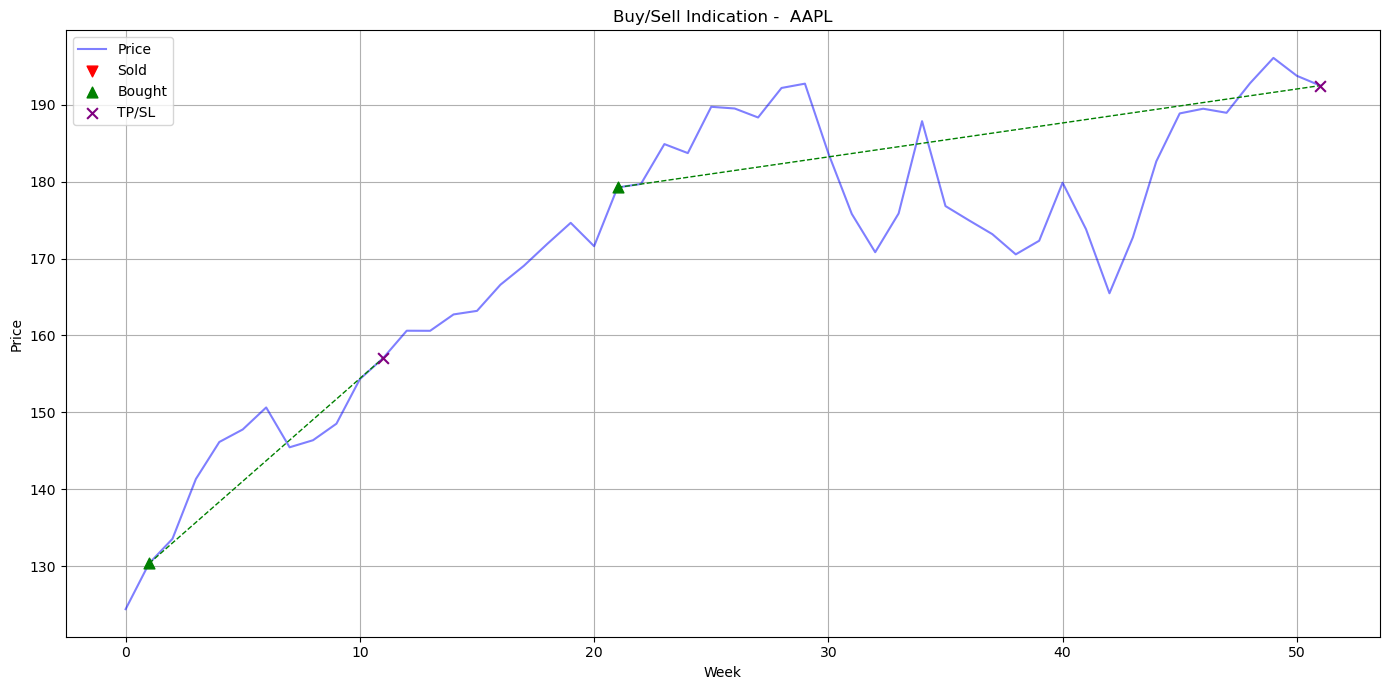


Trade Summary:
Trade 1: Gain: 20.51%
Trade 2: Gain: 7.39%
Total profit for strategy is 27.90%
Total profit for investing is 54.73%


In [106]:
# Test
strategy_A('AAPL', start, end, dy, dz, dx, dw)

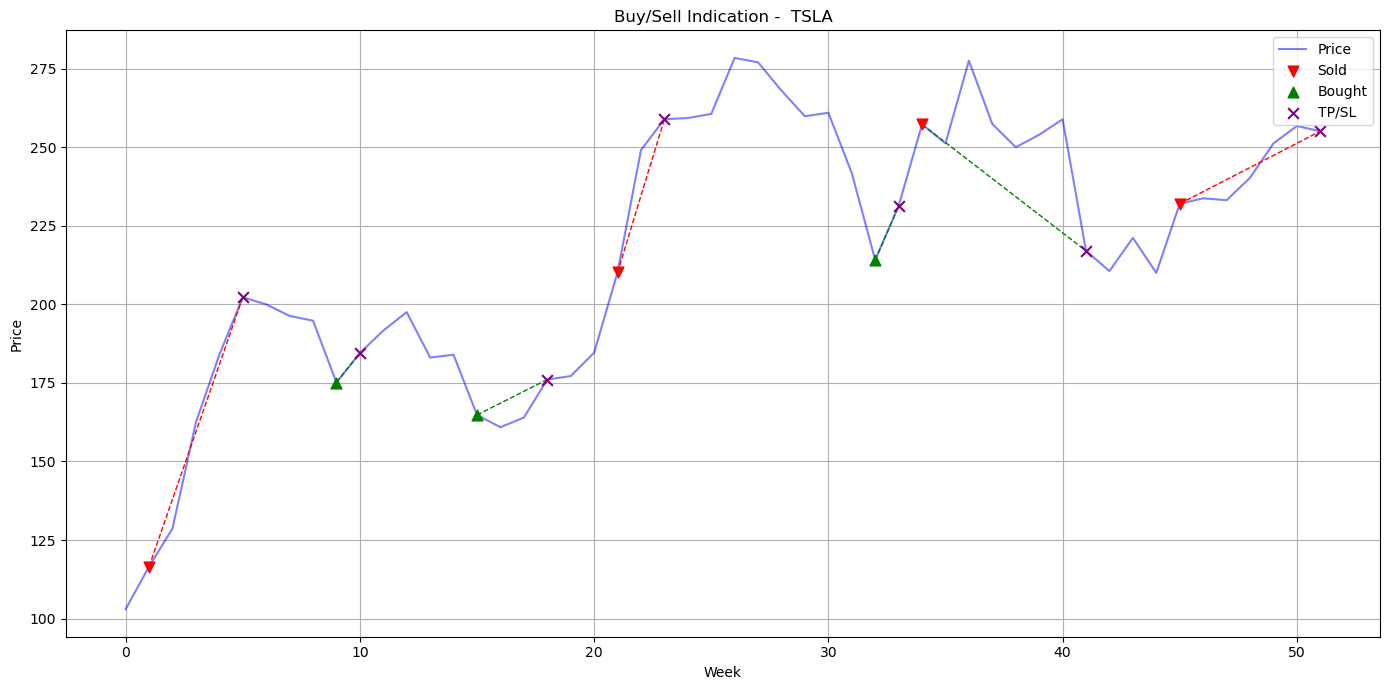


Trade Summary:
Trade 1: Gain: -73.51%
Trade 2: Gain: 5.36%
Trade 3: Gain: 6.84%
Trade 4: Gain: -23.21%
Trade 5: Gain: 8.03%
Trade 6: Gain: 15.65%
Trade 7: Gain: -9.96%
Total profit for strategy is -70.80%
Total profit for investing is 147.67%


In [107]:
# Test
strategy_A('TSLA', start, end, dx, dy, dz, dw)

# $$Daily\ -Strategy\ B$$

One of the possible reason why Strategy A wasn't performing to it's greatest potential was due to limiting the buy/sell points to once weekly. The price can fluctuate dramatically within a week and we can't take profit or stop loss within the week so we now alter the functions slightly to get daily trading.

As it is less likely for a stock to go up/down by $dx$% in a day than in a week we will say that we are looking at the last three days (so the momentum idea holds) with still one position open at a time.

Most the code is identitcal to before.

In [124]:
dx = 0.03
dy = 0.1
dz = 0.1
dw = 0.2

In [125]:
# download DAILY data 
def D_download_data(ticker, start_date, end_date): 
    x = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    prices = x.Close
    dfprices = x[('Close', ticker, )]
    prices_list = [round(price, 2) for price in dfprices]
    return prices_list

In [126]:
# Test
AAPL_D_data = D_download_data('AAPL', '2023-01-01', '2024-01-01')
print(AAPL_D_data)

[123.47, 124.74, 123.42, 127.96, 128.49, 129.06, 131.78, 131.7, 133.04, 134.2, 133.48, 133.54, 136.11, 139.31, 140.71, 140.05, 142.12, 144.06, 141.17, 142.44, 143.57, 148.89, 152.52, 149.79, 152.67, 149.98, 148.94, 149.31, 152.11, 151.47, 153.58, 151.98, 150.83, 146.81, 147.23, 147.71, 145.06, 146.25, 145.75, 143.67, 144.26, 149.33, 152.09, 149.89, 151.15, 148.89, 146.82, 148.77, 150.87, 151.26, 154.09, 153.25, 155.62, 157.48, 156.05, 157.14, 158.44, 156.49, 155.87, 158.96, 160.53, 163.04, 164.3, 163.76, 161.91, 162.8, 160.2, 158.99, 158.29, 163.69, 163.35, 163.37, 164.59, 165.74, 164.77, 163.16, 163.46, 161.92, 161.91, 166.51, 167.77, 167.68, 166.64, 165.56, 163.92, 171.61, 171.54, 169.83, 171.6, 171.79, 170.86, 170.36, 170.36, 170.98, 173.31, 173.42, 172.47, 169.86, 170.14, 171.28, 173.69, 175.54, 175.49, 178.3, 179.16, 177.8, 177.43, 176.06, 178.78, 179.17, 181.97, 181.49, 182.13, 184.17, 183.09, 183.18, 182.14, 185.15, 184.83, 183.43, 186.2, 187.37, 187.71, 192.05, 190.55, 189.43, 

In [127]:
# Daily actions
def D_action_list(stock_price_list, dx, dw):
    actions_list=[0]    
    for i in range(3, len(stock_price_list)):
        # If change is dx in the last two days
        bs_actions=signal(stock_price_list[i-4], stock_price_list[i], dx, dw)  
        actions_list.append(bs_actions)        
    return actions_list

In [128]:
# Test
D_action_list(AAPL_D_data, dx, dw)

[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, -1, -1, 0, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [129]:
def daily_calculate_profits(results_list, prices_list, dy, dz, dx, dw): 
    profits_list = []
    action_points = []
    tpsl_points = []
    i = 0
    while i < len(results_list):
        action = results_list[i]  
        
        action_type, entry_price_str = action.split(' at ')
        entry_price = float(entry_price_str)
        
        if action_type == 'Buy':
            position = 'long'
            
        elif action_type == 'Sell':
            
            position = 'short'
        else:
            i += 1
            continue  
       
        for j in range(i + 1, len(results_list)):
            exit_price = prices_list[j]
            profit = profits(entry_price, exit_price, dy, dz, position)
            
            if profit != 0:
                prev_price = prices_list[j-1]                                 # changed for daily
                three_prev_price = prices_list[j-4] if j > 4 else exit_price  # changed for daily
                sig = signal(three_prev_price, exit_price, dx, dw)
                
                if not ((position == 'long' and sig == 1) or (position == 'short' and sig == -1)):
                    profits_list.append(profit)
                    action_points.append(i)
                    tpsl_points.append(j)
                    sig2 = signal(prev_price, exit_price, dx, dw)                        
                    i = j
                    break
        else:            
            i += 1
            continue
        i += 1
        
    unmatched_position = tpsl_points[-1]
    last_close = len(results_list)    
    
    for _ in range(unmatched_position + 1, len(results_list)):
        action = results_list[_]
        
        action_type, entry_price_str = action.split(' at ')
        entry_price = float(entry_price_str)

        if action_type == 'Buy':
            position = 'long'
            action_points.append(_)
            tpsl_points.append(last_close)
            prof = 100* (prices_list[last_close] - prices_list[_])/prices_list[_]
            profits_list.append(prof)
            break 
            
        elif action_type == 'Sell':
            position = 'short'
            action_points.append(_)
            tpsl_points.append(last_close)
            prof = 100* (prices_list[_] - prices_list[last_close])/prices_list[_]
            profits_list.append(prof)
            break
        else:
            i += 1
            continue  
        
    rounded_list = [round(x, 2) for x in profits_list]
    return rounded_list, action_points, tpsl_points


In [130]:
def strategy_B(ticker, start_date, end_date, dy, dz, dx, dw):
    
    prices_list = D_download_data(ticker, start_date, end_date)       # changed for daily
    actions_list = D_action_list(prices_list, dx, dw)                 # changed for daily
   
    invest_profit = prices_list[-1] - prices_list[0]
    invest_profit_margin = 100*(invest_profit/prices_list[0])
    
    results_list = check_actions(actions_list, prices_list)
    profits_list, time_points, tpsl_points = daily_calculate_profits(results_list, prices_list, dy, dz, dx, dw) # changed for daily

    buy_sell_times = one_position_actions_list(actions_list, time_points)
    tpsl_times = one_position_tpsl_list(time_points, tpsl_points, buy_sell_times)
    
    weeks=list(range(len(prices_list)))

    plt.figure(figsize=(14, 7))  
    plt.plot(weeks, prices_list, 'b-', alpha=0.5, label='Price') 

    sell_weeks = [i for i in range(len(buy_sell_times)) if buy_sell_times[i] == -1] 
    sell_prices = [prices_list[i] for i in sell_weeks]
    plt.scatter(sell_weeks, sell_prices, marker = 'v', color='red', s=60, label='Sold', zorder=5)

    buy_weeks = [i for i in range(len(buy_sell_times)) if buy_sell_times[i] == 1]
    buy_prices = [prices_list[i] for i in buy_weeks]
    plt.scatter(buy_weeks, buy_prices, marker = '^', color='green', s=60, label='Bought', zorder=5)

    tpsl_weeks = [i for i in range(len(tpsl_times)) if tpsl_times[i] !=0]
    tpsl_prices = [prices_list[i] for i in tpsl_weeks]
    plt.scatter(tpsl_weeks, tpsl_prices, marker = 'x', color='purple', s=60, label='TP/SL', zorder=5)

    for i, action in enumerate(buy_sell_times):
        if action == 1:  
            position = 'long'
            for j in range(i + 1, len(tpsl_times)):
            
                if tpsl_times[j] != 0:
                
                    if prices_list[i] - prices_list[j] > 0:
                        plt.plot([i, j], [prices_list[i], prices_list[j]], 
                                 color='red', linestyle='--', linewidth=1)
                        break  
                    
                    elif prices_list[i] - prices_list[j] < 0:
                        plt.plot([i, j], [prices_list[i], prices_list[j]], 
                                 color='green', linestyle='--', linewidth=1)
                        break 
                    
        elif action == -1:  
            position = 'short'
            for j in range(i + 1, len(tpsl_times)):
            
                if tpsl_times[j] != 0:
                
                    if prices_list[i] - prices_list[j] < 0:
                        plt.plot([i, j], [prices_list[i], prices_list[j]], 
                             color='red', linestyle='--', linewidth=1)
                        break  
                    
                    elif prices_list[i] - prices_list[j] > 0:
                        plt.plot([i, j], [prices_list[i], prices_list[j]], 
                                 color='green', linestyle='--', linewidth=1)
                        break  

    plt.title(f'Buy/Sell Indication -  {ticker}')  
    plt.xlabel('Day')  
    plt.ylabel('Price')  
    plt.grid(True)  
    plt.legend(loc='best')
    plt.tight_layout() 
    plt.show() 

    print("\nTrade Summary:")
    for index, profit in enumerate(profits_list, 1):    
        print(f'Trade {index}: Gain: {profit}%')
        total_profit = sum(profits_list)
    print(f'Total profit for strategy is {total_profit:.2f}%')
    print(f'Total profit for investing is {invest_profit_margin:.2f}%')                                      

    return 


    

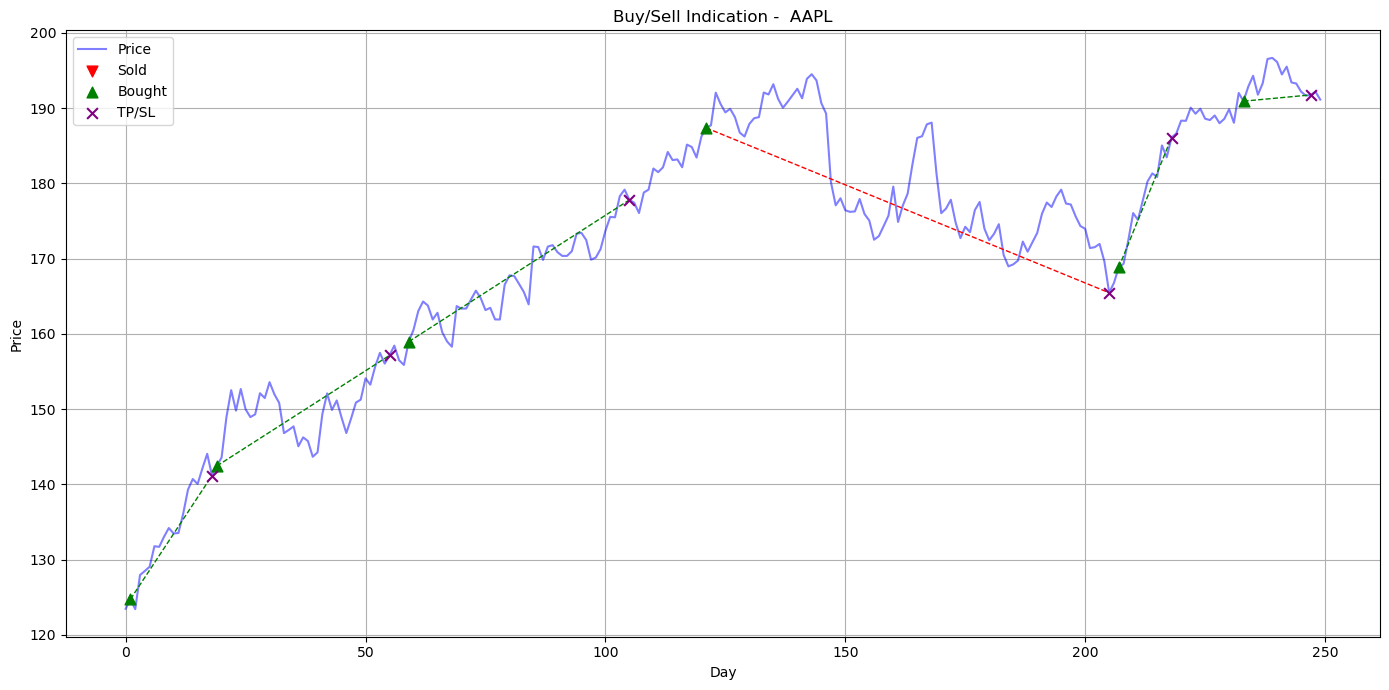


Trade Summary:
Trade 1: Gain: 13.17%
Trade 2: Gain: 10.32%
Trade 3: Gain: 11.85%
Trade 4: Gain: -11.69%
Trade 5: Gain: 10.22%
Trade 6: Gain: 0.43%
Total profit for strategy is 34.30%
Total profit for investing is 54.80%


In [131]:
# Test
strategy_B('AAPL', start, end, dy, dz, dx, dw)

# Analysis

Using this compare function we can easily see that strategy B, as expected, brings a larger and more consistently positive return than strategy A.

In [132]:
def compare(ticker, start_date, end_date, dx, dy, dz, dw):
    strategy_A(ticker, start_date, end_date, dx, dy, dz, dw)
    strategy_B(ticker, start_date, end_date, dx, dy, dz, dw)
    return

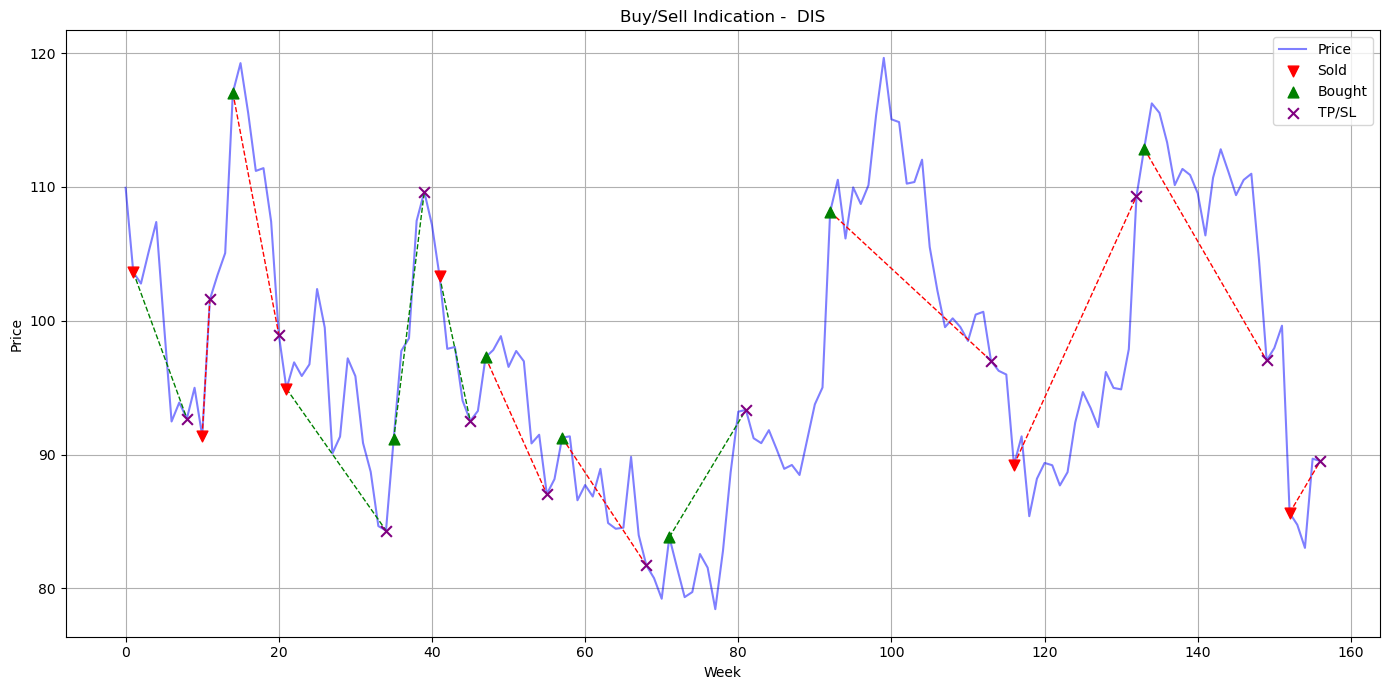


Trade Summary:
Trade 1: Gain: 10.56%
Trade 2: Gain: -11.16%
Trade 3: Gain: -15.45%
Trade 4: Gain: 11.17%
Trade 5: Gain: 20.3%
Trade 6: Gain: 10.45%
Trade 7: Gain: -10.52%
Trade 8: Gain: -10.46%
Trade 9: Gain: 11.36%
Trade 10: Gain: -10.3%
Trade 11: Gain: -22.51%
Trade 12: Gain: -14.03%
Trade 13: Gain: -4.53%
Total profit for strategy is -35.12%
Total profit for investing is -18.58%


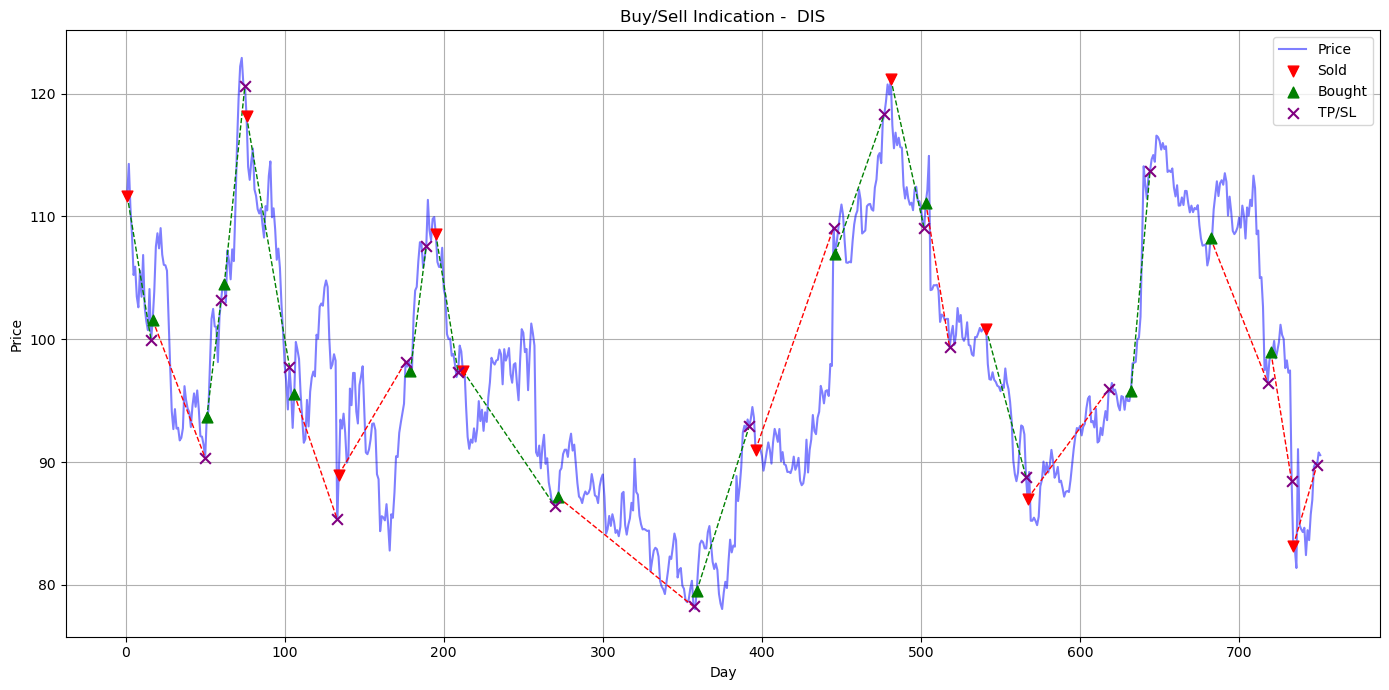


Trade Summary:
Trade 1: Gain: 10.54%
Trade 2: Gain: -11.07%
Trade 3: Gain: 10.19%
Trade 4: Gain: 15.49%
Trade 5: Gain: 17.26%
Trade 6: Gain: -10.69%
Trade 7: Gain: -10.33%
Trade 8: Gain: 10.45%
Trade 9: Gain: 10.36%
Trade 10: Gain: 11.35%
Trade 11: Gain: -10.21%
Trade 12: Gain: 16.88%
Trade 13: Gain: -19.89%
Trade 14: Gain: 10.65%
Trade 15: Gain: 10.05%
Trade 16: Gain: -10.62%
Trade 17: Gain: 11.92%
Trade 18: Gain: -10.22%
Trade 19: Gain: 18.72%
Trade 20: Gain: -10.88%
Trade 21: Gain: -10.59%
Trade 22: Gain: -7.93%
Total profit for strategy is 41.43%
Total profit for investing is -18.88%


In [133]:
compare('DIS', '2022-05-01', '2025-05-01', dy, dz, dx, dw)

## $$Making\ the\ Portfolio$$

This function takes an initial capital and shows the journey it takes through the years.

In [149]:
def portfolio_strategy_B(ticker, start_date, end_date, dy, dz, dx, dw, initial_capital):
    prices_list = D_download_data(ticker, start_date, end_date)       
    actions_list = D_action_list(prices_list, dx, dw)                 

    invest_profit = prices_list[-1] - prices_list[0]
    invest_profit_margin = 100 * (invest_profit / prices_list[0])

    results_list = check_actions(actions_list, prices_list)
    profits_list, time_points, tpsl_points = daily_calculate_profits(results_list, prices_list, dy, dz, dx, dw)  

    buy_sell_times = one_position_actions_list(actions_list, time_points)
    tpsl_times = one_position_tpsl_list(time_points, tpsl_points, buy_sell_times)

    weeks = list(range(len(prices_list)))
    print('-'*240)
    plt.figure(figsize=(14, 7))  
    plt.plot(weeks, prices_list, 'b-', alpha=0.5, label='Price') 

    sell_weeks = [i for i in range(len(buy_sell_times)) if buy_sell_times[i] == -1] 
    sell_prices = [prices_list[i] for i in sell_weeks]
    plt.scatter(sell_weeks, sell_prices, marker='v', color='red', s=60, label='Sold', zorder=5)

    buy_weeks = [i for i in range(len(buy_sell_times)) if buy_sell_times[i] == 1]
    buy_prices = [prices_list[i] for i in buy_weeks]
    plt.scatter(buy_weeks, buy_prices, marker='^', color='green', s=60, label='Bought', zorder=5)

    tpsl_weeks = [i for i in range(len(tpsl_times)) if tpsl_times[i] != 0]
    tpsl_prices = [prices_list[i] for i in tpsl_weeks]
    plt.scatter(tpsl_weeks, tpsl_prices, marker='x', color='purple', s=60, label='TP/SL', zorder=5)

    for i, action in enumerate(buy_sell_times):
        if action == 1:  # Buy
            for j in range(i + 1, len(tpsl_times)):
                if tpsl_times[j] != 0:
                    color = 'green' if prices_list[j] > prices_list[i] else 'red'
                    plt.plot([i, j], [prices_list[i], prices_list[j]],
                             color=color, linestyle='--', linewidth=1)
                    break
        elif action == -1:  # Sell
            for j in range(i + 1, len(tpsl_times)):
                if tpsl_times[j] != 0:
                    color = 'green' if prices_list[j] < prices_list[i] else 'red'
                    plt.plot([i, j], [prices_list[i], prices_list[j]],
                             color=color, linestyle='--', linewidth=1)
                    break

    plt.title(f'Buy/Sell Indication - {ticker}')  
    plt.xlabel('Day')  
    plt.ylabel('Price')  
    plt.grid(True)  
    plt.legend(loc='best')
    plt.tight_layout() 
    plt.show()

    # Portfolio Calculation 
    
    print("\nTrade Summary:")
    portfolio_value = initial_capital
    print(f'Initial Capital: {portfolio_value:.2f}')
    portfolio_value = initial_capital
    capital_history = [portfolio_value]
    trade_days = [0]

    for index, profit in enumerate(profits_list):
        gain = (profit / 100.0) * portfolio_value
        portfolio_value += gain
        capital_history.append(portfolio_value)

        # Trade day from time_points or fallback
        if index < len(time_points):
            trade_day = time_points[index]
        else:
            trade_day = trade_days[-1] + 1

        trade_days.append(trade_day)

        print(f'Trade {index + 1}: Gain: {profit:.2f}%, Portfolio: ${portfolio_value:.2f}')
    final_value = capital_history[-1]
    total_profit = 100*(final_value - initial_capital)/initial_capital
    print(f'\nTotal strategy profit: {total_profit:.2f}%')
    print(f'Total investing (buy & hold) profit: {invest_profit_margin:.2f}%')
    print(f'Final portfolio value: ${portfolio_value:.2f}')
    

    # ---- Portfolio Value Plot ----
    plt.figure(figsize=(12, 6))
    plt.plot(trade_days, capital_history, marker='o', linestyle='-', color='orange')
    plt.title(f'Portfolio Value Over Time - {ticker}')
    plt.xlabel('Trade # or Approx. Day')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print('-'*240)

    return final_value



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


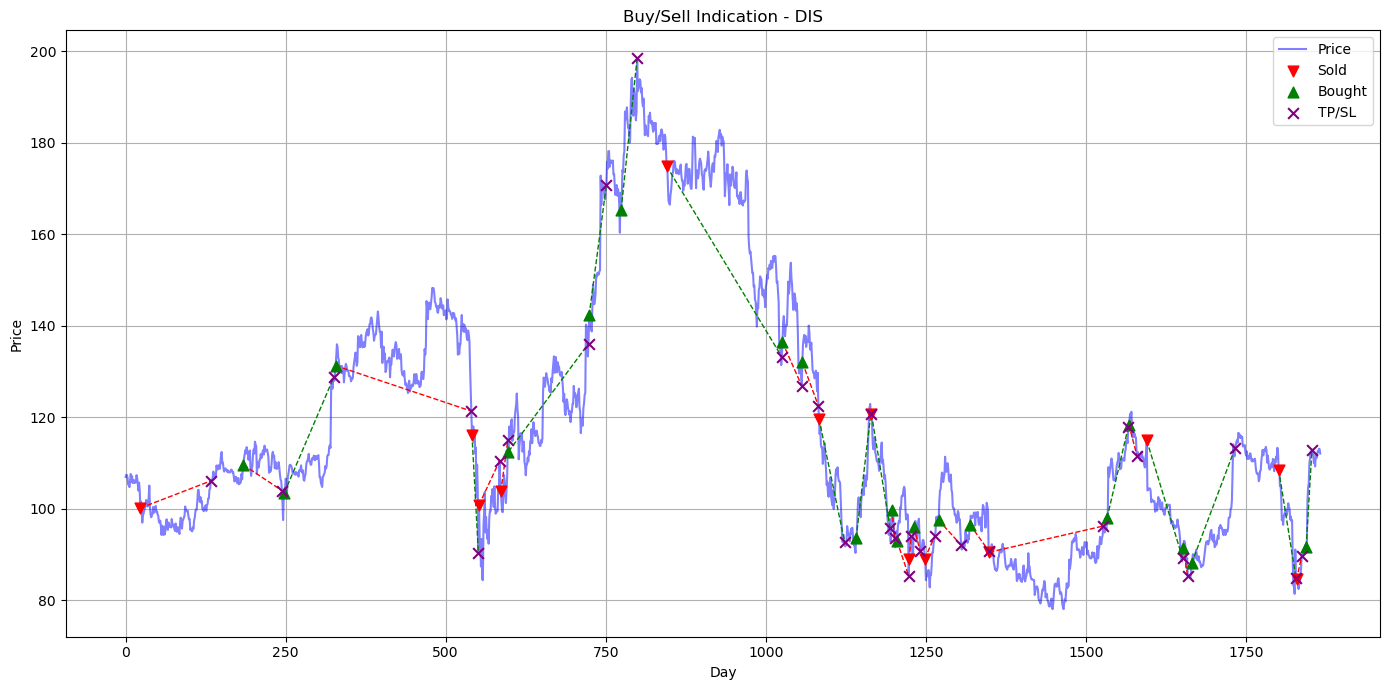


Trade Summary:
Initial Capital: 100000.00
Trade 1: Gain: -5.91%, Portfolio: $94090.00
Trade 2: Gain: -5.11%, Portfolio: $89282.00
Trade 3: Gain: 24.35%, Portfolio: $111022.17
Trade 4: Gain: -7.57%, Portfolio: $102617.79
Trade 5: Gain: 22.22%, Portfolio: $125419.46
Trade 6: Gain: -9.49%, Portfolio: $113517.16
Trade 7: Gain: -10.75%, Portfolio: $101314.06
Trade 8: Gain: 20.98%, Portfolio: $122569.75
Trade 9: Gain: 20.08%, Portfolio: $147181.76
Trade 10: Gain: 20.07%, Portfolio: $176721.14
Trade 11: Gain: 23.86%, Portfolio: $218886.80
Trade 12: Gain: -6.93%, Portfolio: $203717.94
Trade 13: Gain: -7.17%, Portfolio: $189111.37
Trade 14: Gain: 22.46%, Portfolio: $231585.78
Trade 15: Gain: 29.00%, Portfolio: $298745.66
Trade 16: Gain: 20.56%, Portfolio: $360167.77
Trade 17: Gain: -6.19%, Portfolio: $337873.38
Trade 18: Gain: -8.15%, Portfolio: $310336.70
Trade 19: Gain: -5.57%, Portfolio: $293050.95
Trade 20: Gain: -5.42%, Portfolio: $277167.58
Trade 21: Gain: -5.59%, Portfolio: $261673.92
T

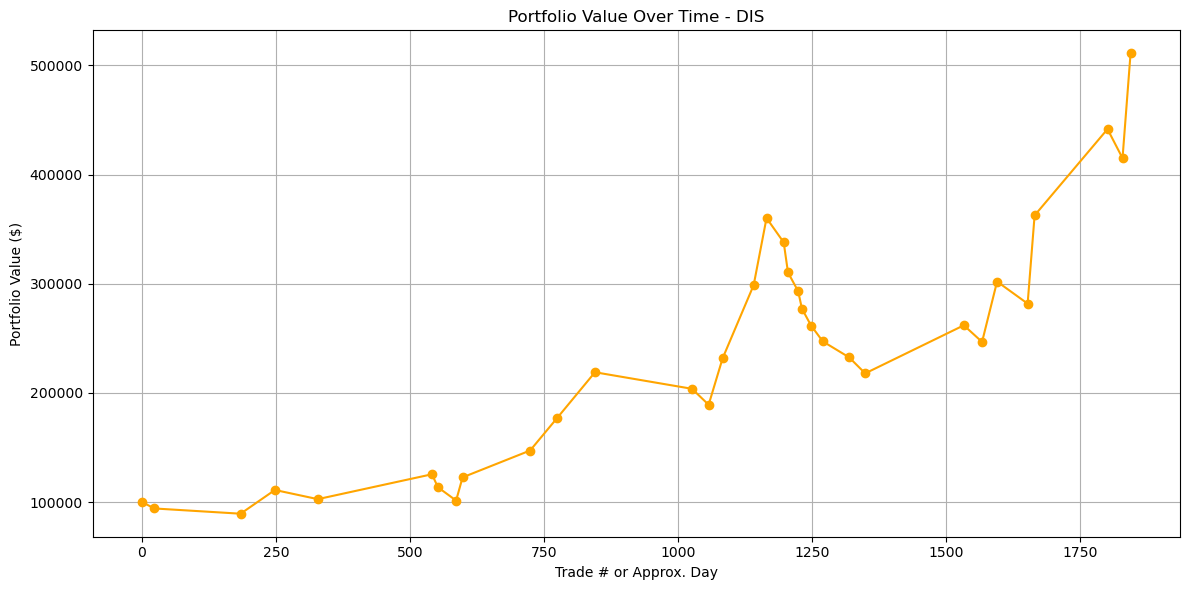

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


511062.4143622697

In [163]:
dx = 0.05
dy = 0.2
dz = 0.05
dw = 0.2
portfolio_strategy_B('DIS', '2018-01-01', '2025-06-06', dy, dz, dx, dw, 100000)

## List of tickers

A function that gives a random list of tickers of a random length.

In [164]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)
sp500 = table[0]  # First table contains the companies
big_tickers_list = sp500['Symbol'].tolist()
def tickers_random_list(tickers, length):
    result = []
    while len(result) < length:
        i = random.randint(0, len(tickers) - 1)
        result.append(tickers[i])
    return result   

In [165]:
def diversify(tickers, start_date, end_date, dy, dz, dx, dw, initial_capital, length):
    tickers_list = tickers_random_list(tickers, length)

    capital_per_stock = initial_capital / length
    results_list = []

    for ticker in tickers_list:
        print(f'\nRunning strategy for {ticker}...')
        value = portfolio_strategy_B(ticker, start_date, end_date, dy, dz, dx, dw, capital_per_stock)
        results_list.append((ticker, value))

    # Unpack into separate lists
    ticker_list, value_list = zip(*results_list) 

    total = sum(value_list)
    p_change = 100*(total - initial_capital)/initial_capital
    print(f'\nTotal Combined Value: ${total:.2f}')
    print(f'\nTotal Return: {p_change:.2f}%')
    
    return



Running strategy for ITW...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


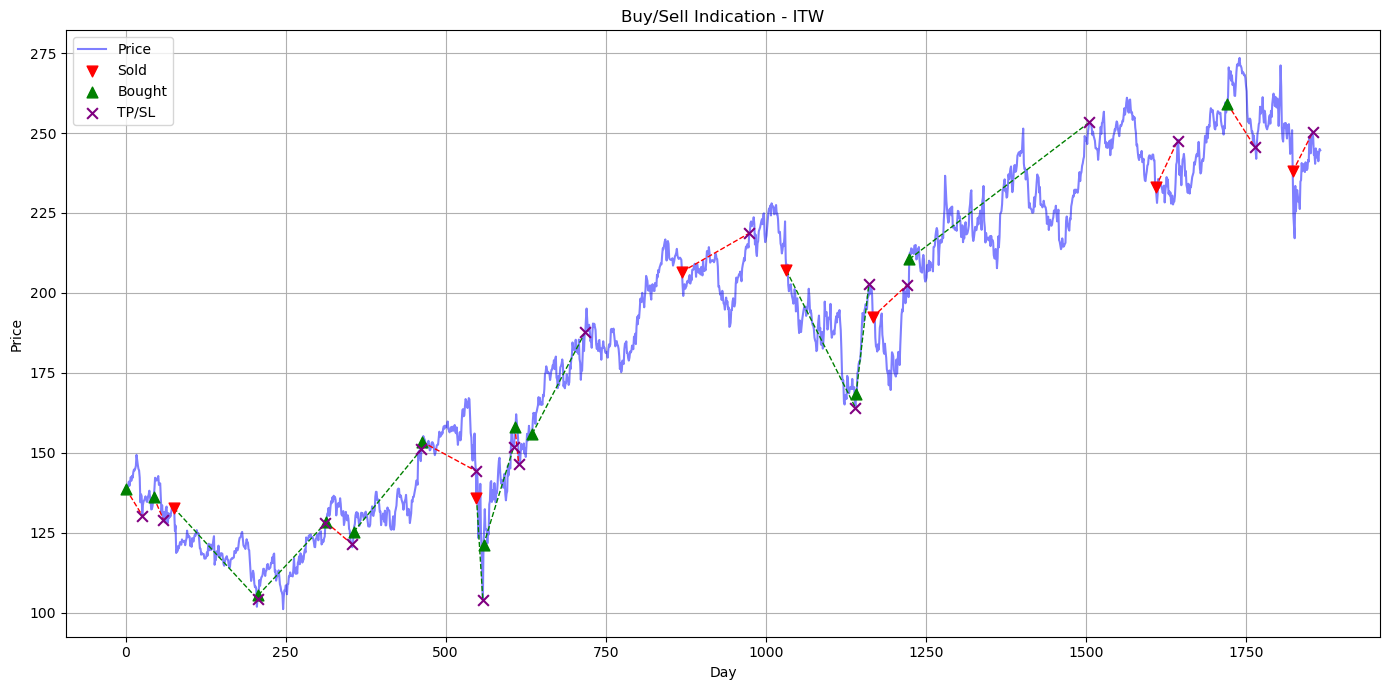


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: -5.91%, Portfolio: $9409.00
Trade 2: Gain: -5.13%, Portfolio: $8926.32
Trade 3: Gain: 21.52%, Portfolio: $10847.26
Trade 4: Gain: 21.34%, Portfolio: $13162.07
Trade 5: Gain: -5.29%, Portfolio: $12465.79
Trade 6: Gain: 20.65%, Portfolio: $15039.98
Trade 7: Gain: -5.93%, Portfolio: $14148.11
Trade 8: Gain: 23.58%, Portfolio: $17484.23
Trade 9: Gain: 25.28%, Portfolio: $21904.25
Trade 10: Gain: -7.44%, Portfolio: $20274.57
Trade 11: Gain: 20.52%, Portfolio: $24434.91
Trade 12: Gain: -5.83%, Portfolio: $23010.36
Trade 13: Gain: 20.76%, Portfolio: $27787.31
Trade 14: Gain: 20.40%, Portfolio: $33455.92
Trade 15: Gain: -5.23%, Portfolio: $31706.18
Trade 16: Gain: 20.31%, Portfolio: $38145.70
Trade 17: Gain: -6.21%, Portfolio: $35776.85
Trade 18: Gain: -5.24%, Portfolio: $33902.15
Trade 19: Gain: -5.13%, Portfolio: $32162.97

Total strategy profit: 221.63%
Total investing (buy & hold) profit: 77.33%
Final portfolio value: $32162.97


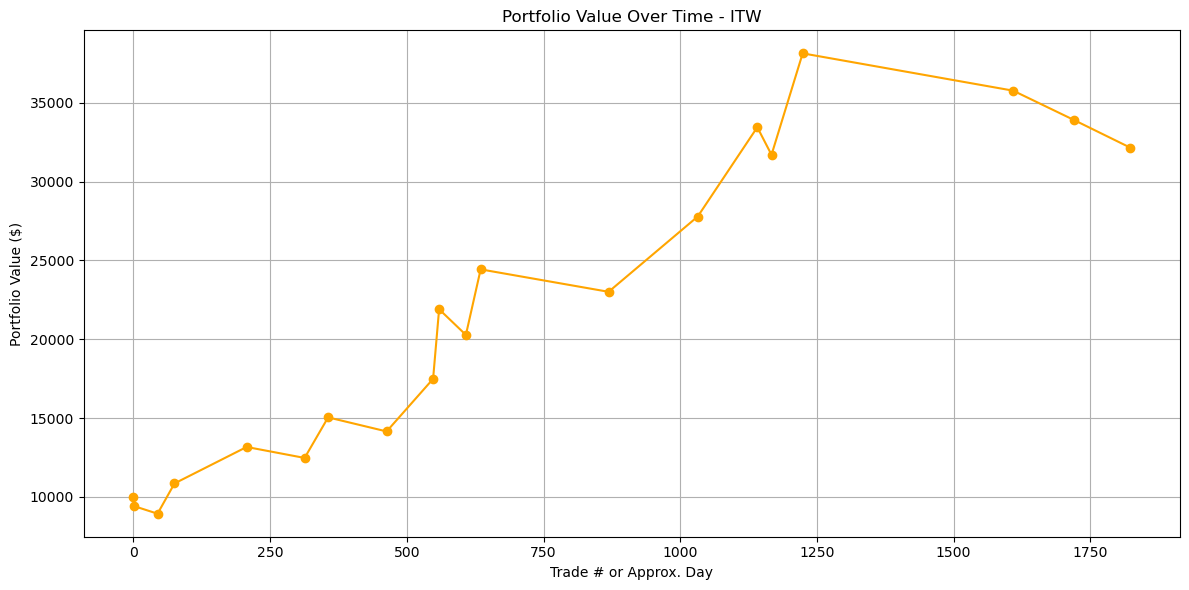

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for FANG...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


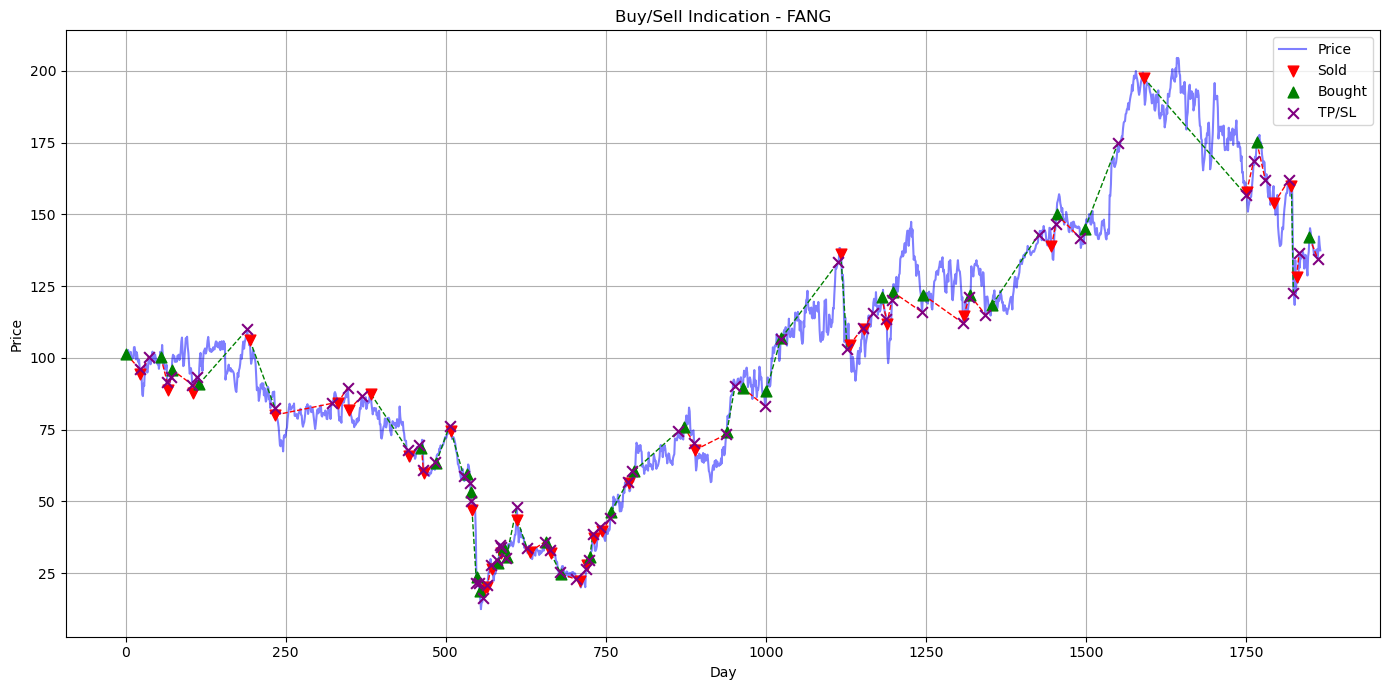


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: -5.19%, Portfolio: $9481.00
Trade 2: Gain: -6.36%, Portfolio: $8878.01
Trade 3: Gain: -8.73%, Portfolio: $8102.96
Trade 4: Gain: -5.08%, Portfolio: $7691.33
Trade 5: Gain: -5.47%, Portfolio: $7270.61
Trade 6: Gain: -6.42%, Portfolio: $6803.84
Trade 7: Gain: 21.19%, Portfolio: $8245.57
Trade 8: Gain: 22.15%, Portfolio: $10071.97
Trade 9: Gain: -5.09%, Portfolio: $9559.30
Trade 10: Gain: -6.46%, Portfolio: $8941.77
Trade 11: Gain: -5.72%, Portfolio: $8430.30
Trade 12: Gain: 22.35%, Portfolio: $10314.48
Trade 13: Gain: -5.45%, Portfolio: $9752.34
Trade 14: Gain: -11.05%, Portfolio: $8674.70
Trade 15: Gain: -6.88%, Portfolio: $8077.88
Trade 16: Gain: 20.62%, Portfolio: $9743.54
Trade 17: Gain: 21.15%, Portfolio: $11804.30
Trade 18: Gain: -5.18%, Portfolio: $11192.84
Trade 19: Gain: -5.98%, Portfolio: $10523.51
Trade 20: Gain: 54.54%, Portfolio: $16263.03
Trade 21: Gain: -8.37%, Portfolio: $14901.81
Trade 22: Gain: -13.29%, Portfolio:

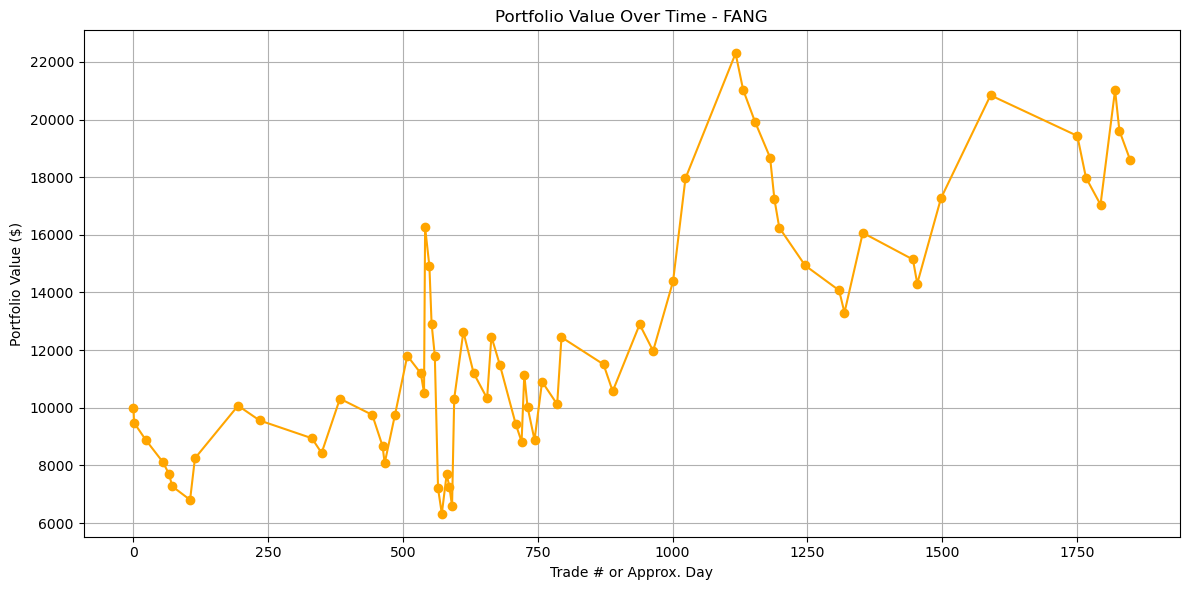

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for AVGO...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


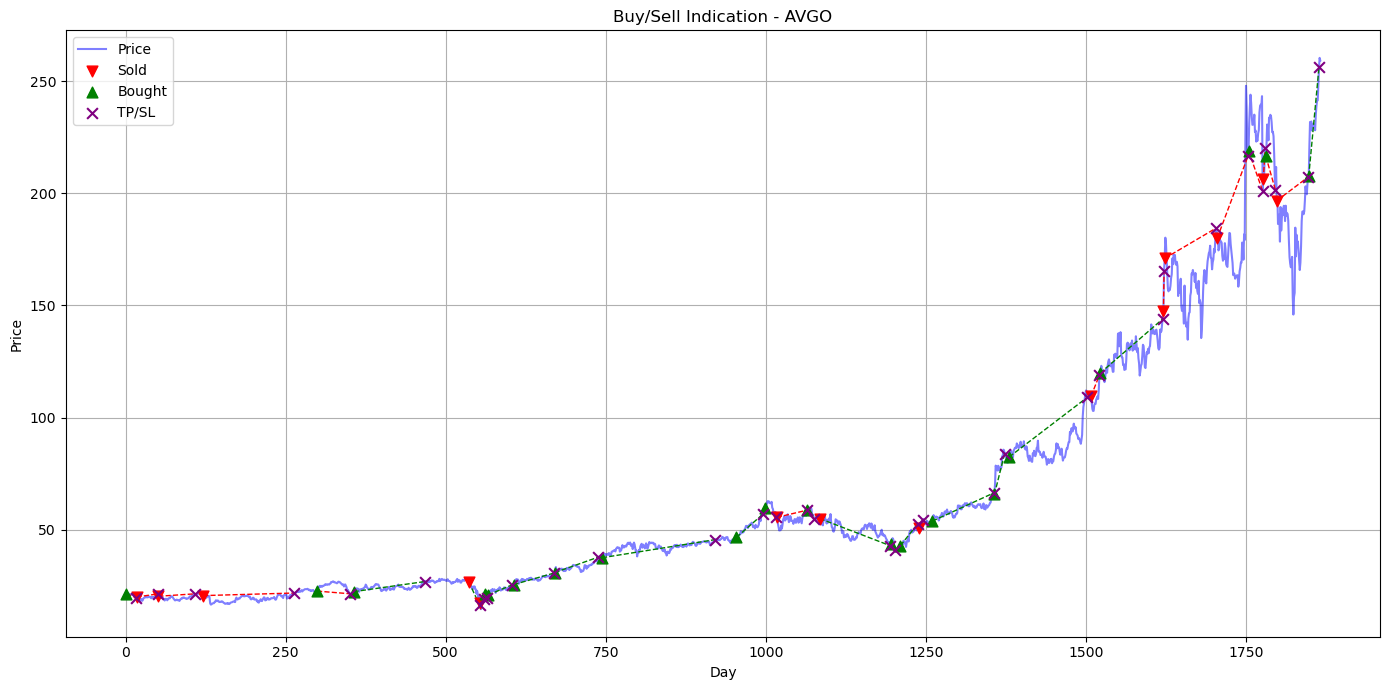


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: -8.40%, Portfolio: $9160.00
Trade 2: Gain: -6.78%, Portfolio: $8538.95
Trade 3: Gain: -5.39%, Portfolio: $8078.70
Trade 4: Gain: -5.60%, Portfolio: $7626.30
Trade 5: Gain: -5.32%, Portfolio: $7220.58
Trade 6: Gain: 20.19%, Portfolio: $8678.41
Trade 7: Gain: 39.33%, Portfolio: $12091.63
Trade 8: Gain: -10.85%, Portfolio: $10779.69
Trade 9: Gain: -8.01%, Portfolio: $9916.23
Trade 10: Gain: 21.28%, Portfolio: $12026.41
Trade 11: Gain: 20.15%, Portfolio: $14449.73
Trade 12: Gain: 22.34%, Portfolio: $17677.80
Trade 13: Gain: 21.51%, Portfolio: $21480.30
Trade 14: Gain: 22.18%, Portfolio: $26244.63
Trade 15: Gain: -6.83%, Portfolio: $24452.12
Trade 16: Gain: -5.75%, Portfolio: $23046.12
Trade 17: Gain: -6.66%, Portfolio: $21511.25
Trade 18: Gain: 22.02%, Portfolio: $26248.03
Trade 19: Gain: -5.71%, Portfolio: $24749.26
Trade 20: Gain: 22.52%, Portfolio: $30322.80
Trade 21: Gain: -7.60%, Portfolio: $28018.27
Trade 22: Gain: 23.42%, Port

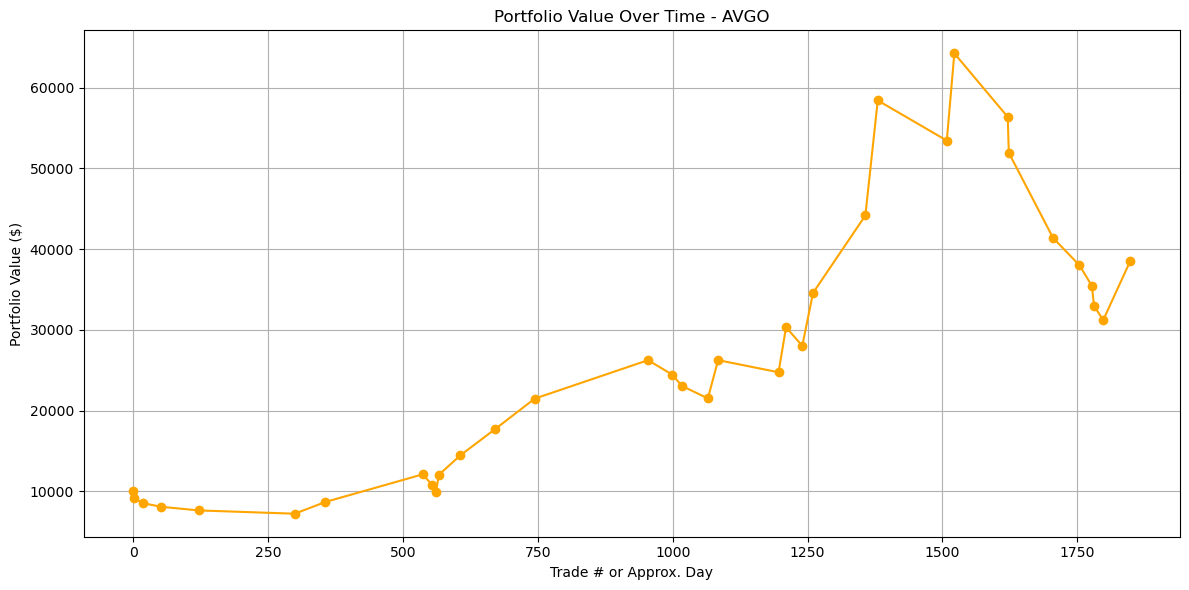

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for SPG...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


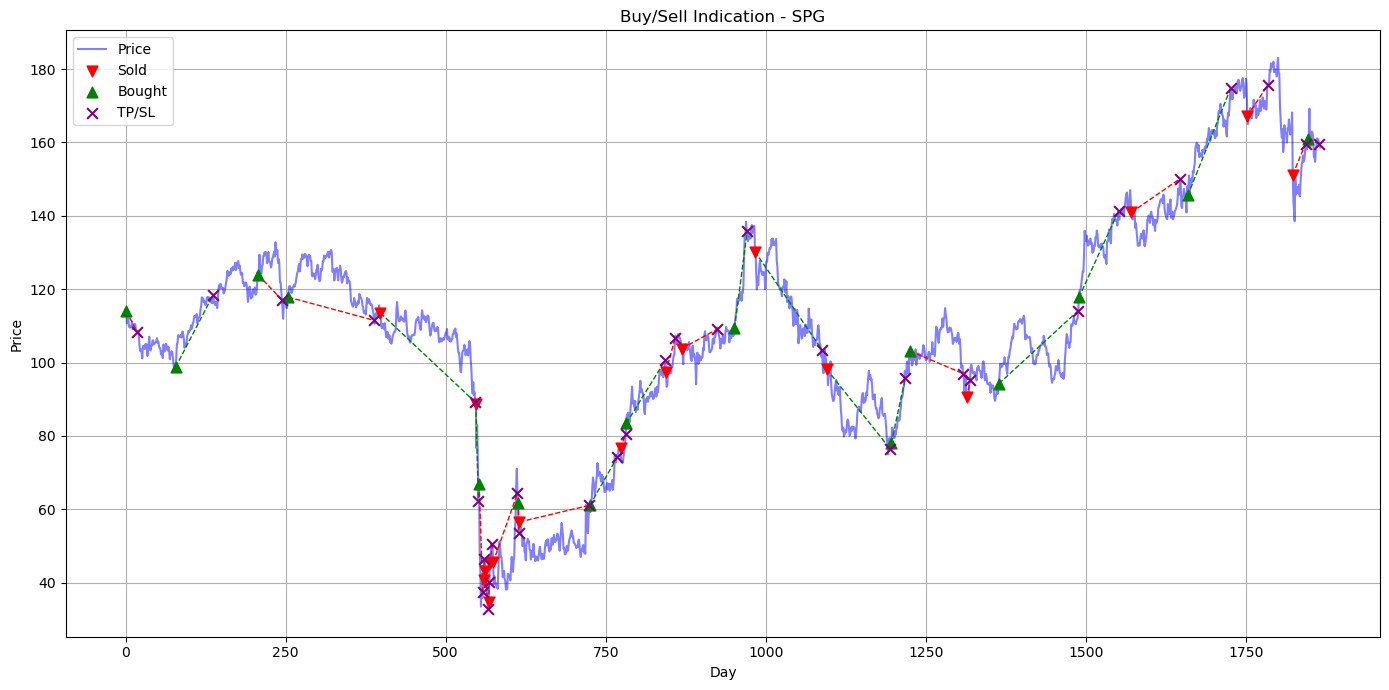


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: -5.08%, Portfolio: $9492.00
Trade 2: Gain: 20.06%, Portfolio: $11396.10
Trade 3: Gain: -5.50%, Portfolio: $10769.31
Trade 4: Gain: -5.37%, Portfolio: $10191.00
Trade 5: Gain: 21.42%, Portfolio: $12373.91
Trade 6: Gain: 29.87%, Portfolio: $16070.00
Trade 7: Gain: -44.13%, Portfolio: $8978.31
Trade 8: Gain: -13.90%, Portfolio: $7730.32
Trade 9: Gain: 24.34%, Portfolio: $9611.88
Trade 10: Gain: -15.71%, Portfolio: $8101.86
Trade 11: Gain: -11.28%, Portfolio: $7187.97
Trade 12: Gain: -41.24%, Portfolio: $4223.65
Trade 13: Gain: -13.36%, Portfolio: $3659.37
Trade 14: Gain: -8.00%, Portfolio: $3366.62
Trade 15: Gain: 21.58%, Portfolio: $4093.14
Trade 16: Gain: -5.17%, Portfolio: $3881.52
Trade 17: Gain: 20.67%, Portfolio: $4683.83
Trade 18: Gain: -9.43%, Portfolio: $4242.15
Trade 19: Gain: -5.01%, Portfolio: $4029.62
Trade 20: Gain: 24.28%, Portfolio: $5008.01
Trade 21: Gain: 20.66%, Portfolio: $6042.66
Trade 22: Gain: 22.11%, Portfoli

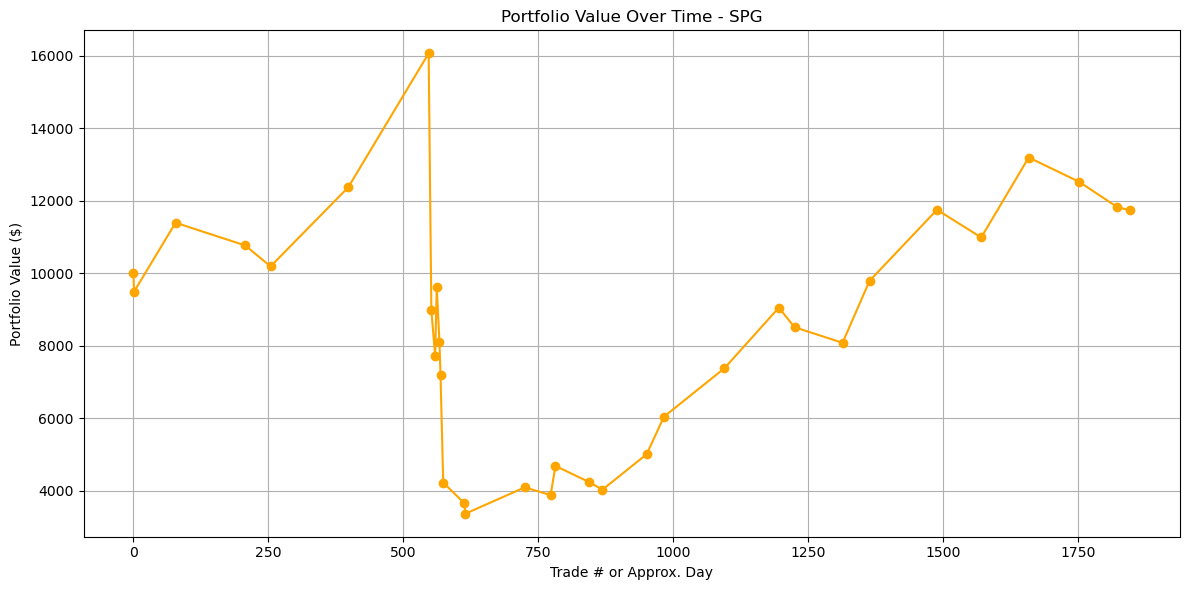

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for CLX...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


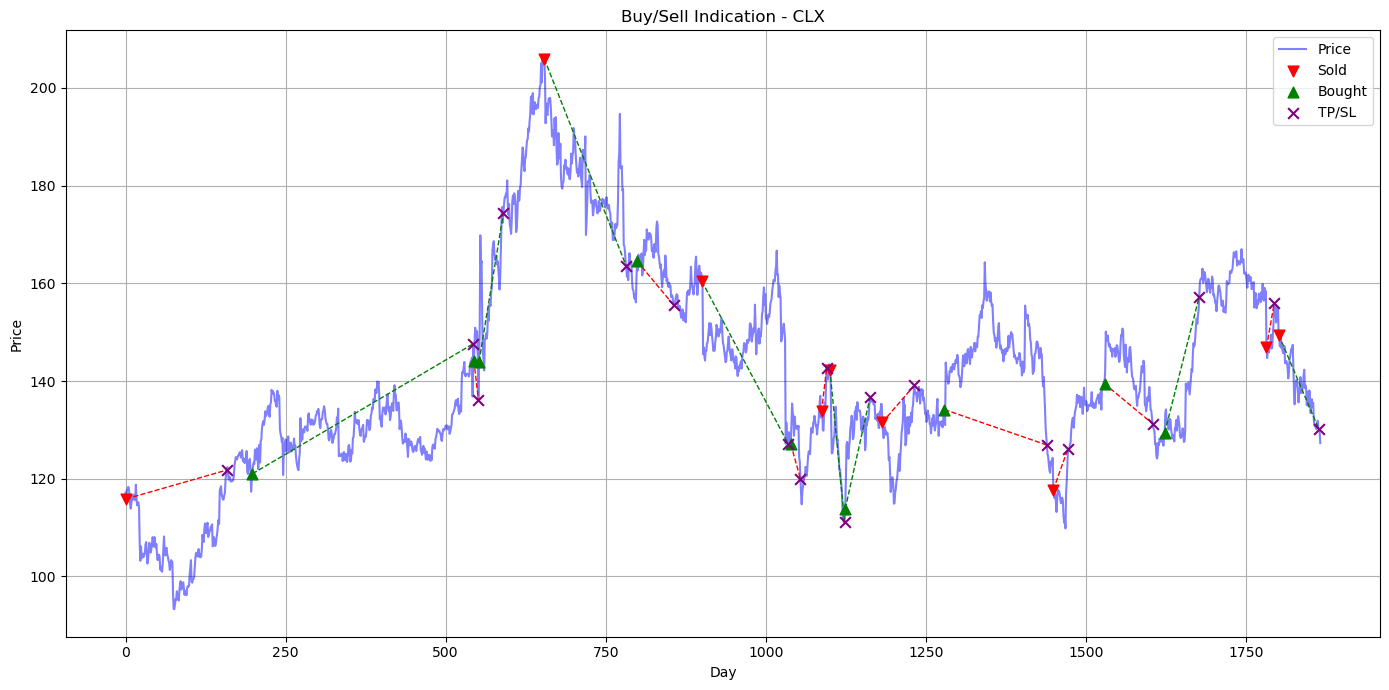


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: -5.08%, Portfolio: $9492.00
Trade 2: Gain: 21.99%, Portfolio: $11579.29
Trade 3: Gain: -5.46%, Portfolio: $10947.06
Trade 4: Gain: 21.06%, Portfolio: $13252.51
Trade 5: Gain: 20.60%, Portfolio: $15982.53
Trade 6: Gain: -5.45%, Portfolio: $15111.48
Trade 7: Gain: 20.76%, Portfolio: $18248.63
Trade 8: Gain: -5.55%, Portfolio: $17235.83
Trade 9: Gain: -6.58%, Portfolio: $16101.71
Trade 10: Gain: 21.88%, Portfolio: $19624.76
Trade 11: Gain: 20.16%, Portfolio: $23581.12
Trade 12: Gain: -5.76%, Portfolio: $22222.84
Trade 13: Gain: -5.41%, Portfolio: $21020.59
Trade 14: Gain: -7.13%, Portfolio: $19521.82
Trade 15: Gain: -5.85%, Portfolio: $18379.79
Trade 16: Gain: 21.54%, Portfolio: $22338.80
Trade 17: Gain: -6.10%, Portfolio: $20976.13
Trade 18: Gain: 12.97%, Portfolio: $23696.74

Total strategy profit: 136.97%
Total investing (buy & hold) profit: 8.67%
Final portfolio value: $23696.74


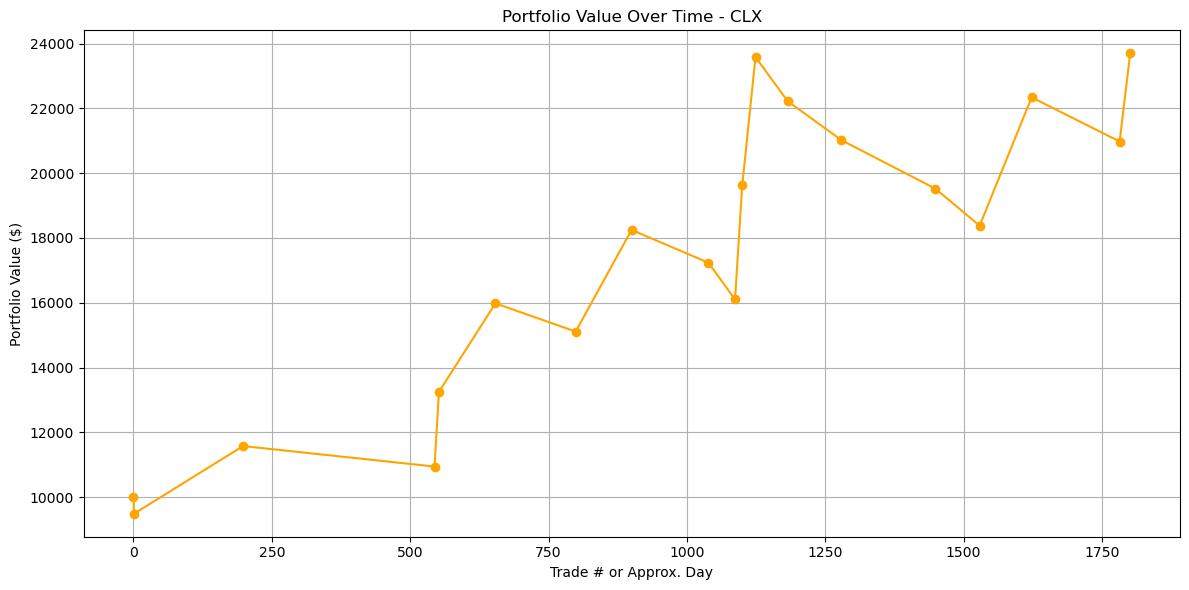

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for DPZ...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


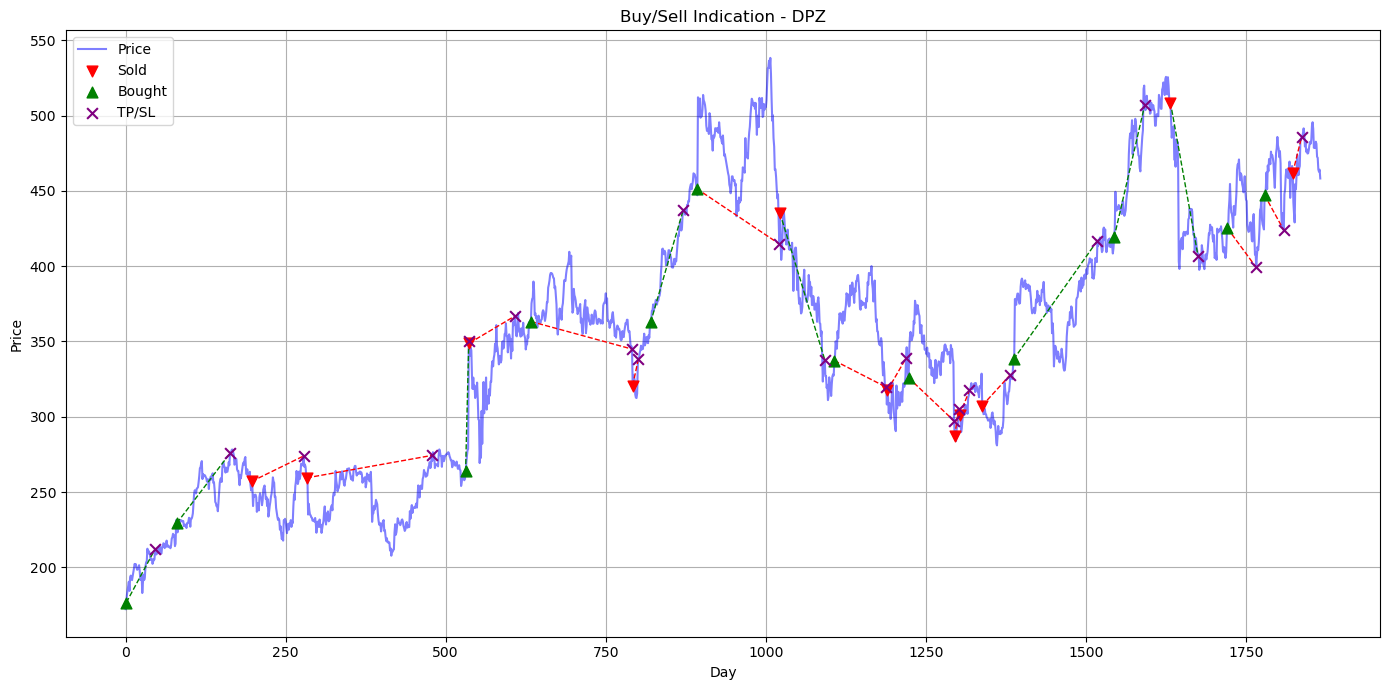


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: 20.14%, Portfolio: $12014.00
Trade 2: Gain: 20.18%, Portfolio: $14438.43
Trade 3: Gain: -6.55%, Portfolio: $13492.71
Trade 4: Gain: -5.73%, Portfolio: $12719.58
Trade 5: Gain: 32.78%, Portfolio: $16889.05
Trade 6: Gain: -5.13%, Portfolio: $16022.64
Trade 7: Gain: -5.04%, Portfolio: $15215.10
Trade 8: Gain: -5.58%, Portfolio: $14366.10
Trade 9: Gain: 20.62%, Portfolio: $17328.39
Trade 10: Gain: -8.13%, Portfolio: $15919.59
Trade 11: Gain: 22.36%, Portfolio: $19479.21
Trade 12: Gain: -5.16%, Portfolio: $18474.09
Trade 13: Gain: -6.69%, Portfolio: $17238.17
Trade 14: Gain: -8.79%, Portfolio: $15722.93
Trade 15: Gain: -6.34%, Portfolio: $14726.10
Trade 16: Gain: -5.37%, Portfolio: $13935.31
Trade 17: Gain: -6.69%, Portfolio: $13003.04
Trade 18: Gain: 23.35%, Portfolio: $16039.25
Trade 19: Gain: 21.06%, Portfolio: $19417.11
Trade 20: Gain: 20.02%, Portfolio: $23304.42
Trade 21: Gain: -6.13%, Portfolio: $21875.86
Trade 22: Gain: -5.21%

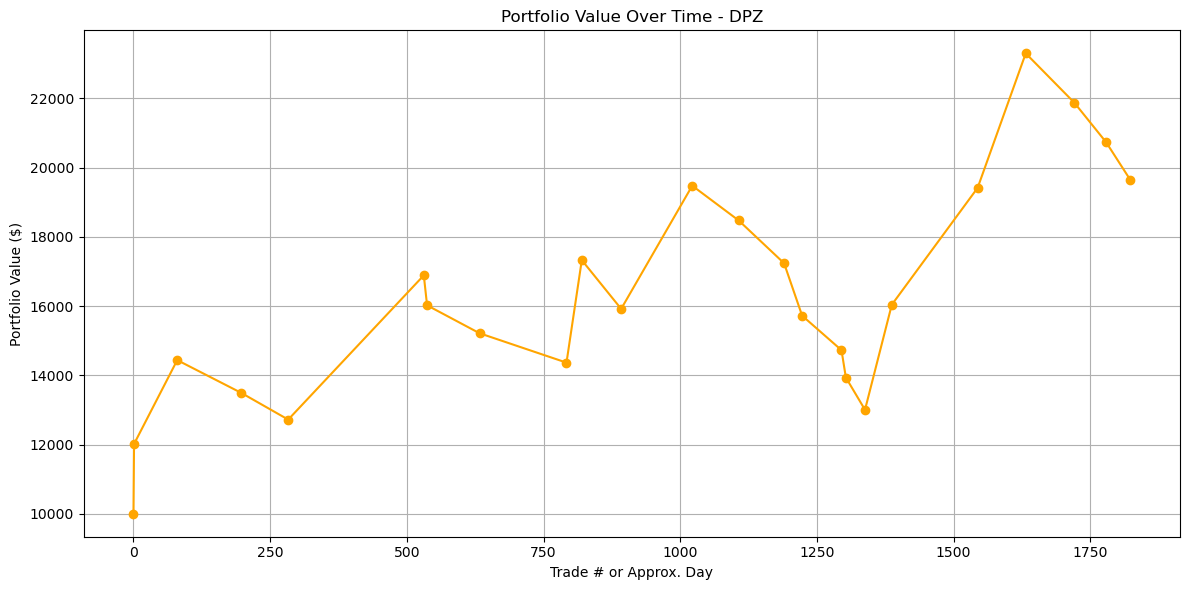

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for FTV...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


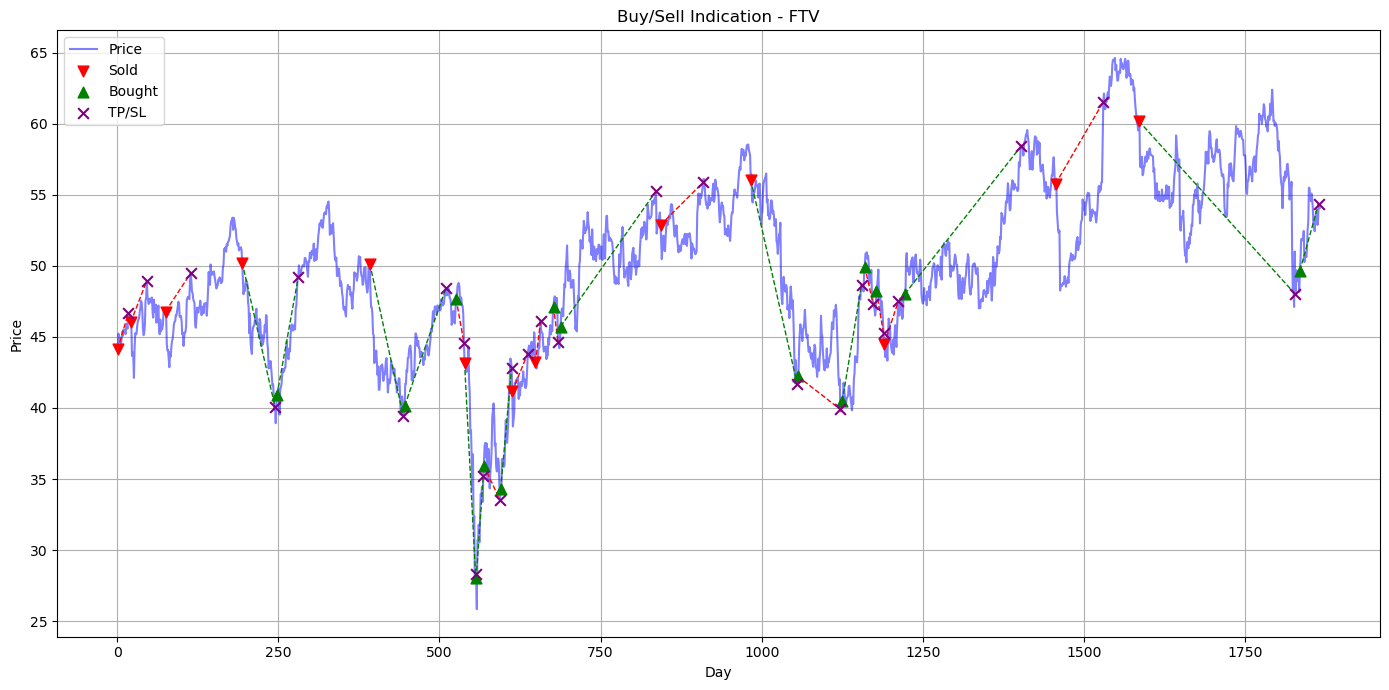


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: -5.73%, Portfolio: $9427.00
Trade 2: Gain: -6.34%, Portfolio: $8829.33
Trade 3: Gain: -5.75%, Portfolio: $8321.64
Trade 4: Gain: 20.23%, Portfolio: $10005.11
Trade 5: Gain: 20.28%, Portfolio: $12034.15
Trade 6: Gain: 21.40%, Portfolio: $14609.45
Trade 7: Gain: 20.60%, Portfolio: $17619.00
Trade 8: Gain: -6.46%, Portfolio: $16480.81
Trade 9: Gain: 34.41%, Portfolio: $22151.86
Trade 10: Gain: 25.62%, Portfolio: $27827.17
Trade 11: Gain: -6.82%, Portfolio: $25929.36
Trade 12: Gain: 24.90%, Portfolio: $32385.77
Trade 13: Gain: -6.46%, Portfolio: $30293.64
Trade 14: Gain: -6.76%, Portfolio: $28245.79
Trade 15: Gain: -5.33%, Portfolio: $26740.29
Trade 16: Gain: 20.84%, Portfolio: $32312.97
Trade 17: Gain: -5.65%, Portfolio: $30487.29
Trade 18: Gain: 25.63%, Portfolio: $38301.18
Trade 19: Gain: -5.52%, Portfolio: $36186.95
Trade 20: Gain: 20.26%, Portfolio: $43518.43
Trade 21: Gain: -5.31%, Portfolio: $41207.60
Trade 22: Gain: -6.10%, P

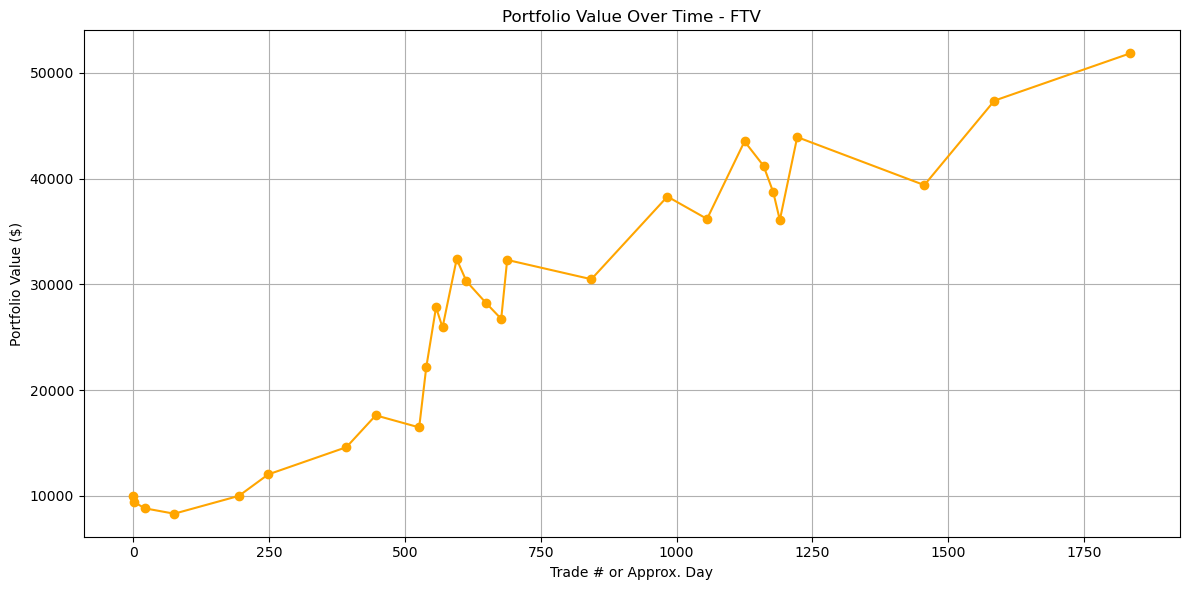

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for WDC...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


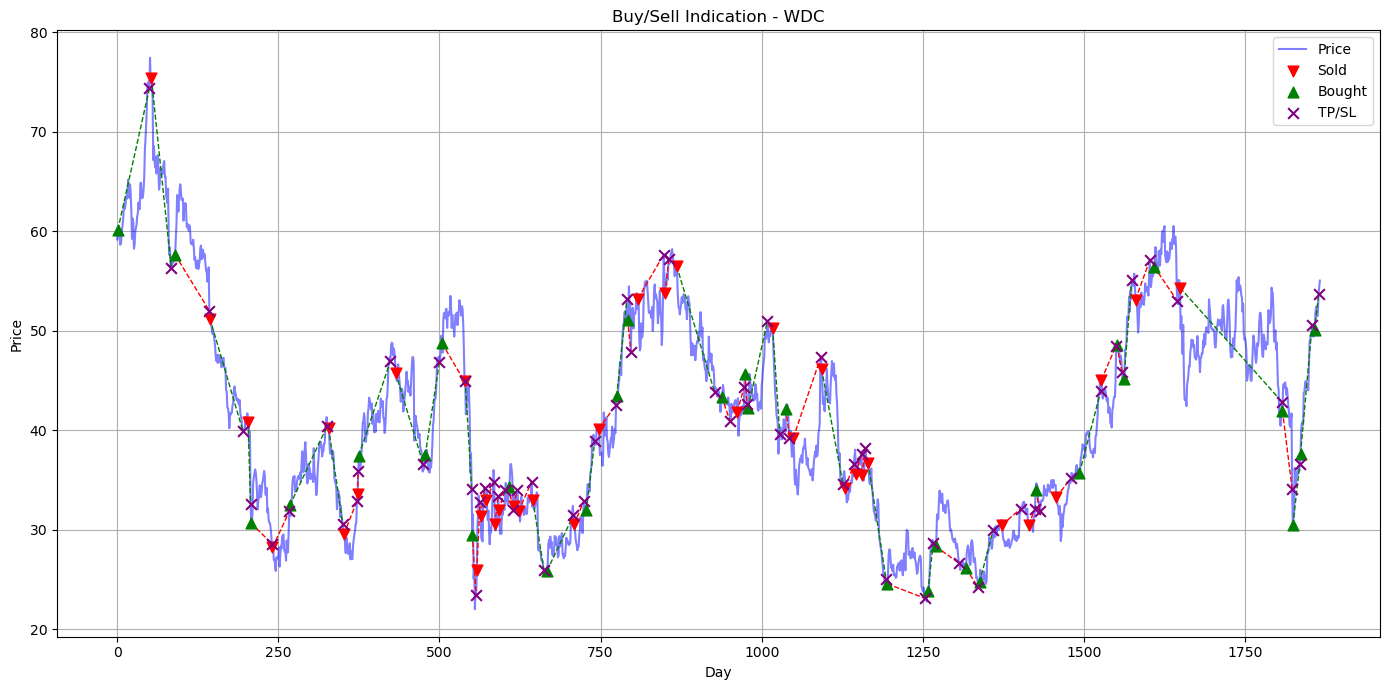


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: 23.66%, Portfolio: $12366.00
Trade 2: Gain: 25.35%, Portfolio: $15500.78
Trade 3: Gain: -9.73%, Portfolio: $13992.56
Trade 4: Gain: 22.00%, Portfolio: $17070.92
Trade 5: Gain: 20.18%, Portfolio: $20515.83
Trade 6: Gain: -6.66%, Portfolio: $19149.47
Trade 7: Gain: -12.83%, Portfolio: $16692.60
Trade 8: Gain: 24.58%, Portfolio: $20795.64
Trade 9: Gain: 24.01%, Portfolio: $25788.67
Trade 10: Gain: -11.19%, Portfolio: $22902.92
Trade 11: Gain: -6.72%, Portfolio: $21363.84
Trade 12: Gain: 25.41%, Portfolio: $26792.39
Trade 13: Gain: 20.07%, Portfolio: $32169.63
Trade 14: Gain: 24.85%, Portfolio: $40163.78
Trade 15: Gain: -7.88%, Portfolio: $36998.87
Trade 16: Gain: 24.28%, Portfolio: $45982.20
Trade 17: Gain: -20.60%, Portfolio: $36509.87
Trade 18: Gain: -26.61%, Portfolio: $26794.59
Trade 19: Gain: -8.95%, Portfolio: $24396.47
Trade 20: Gain: -5.33%, Portfolio: $23096.14
Trade 21: Gain: -9.20%, Portfolio: $20971.30
Trade 22: Gain: -6

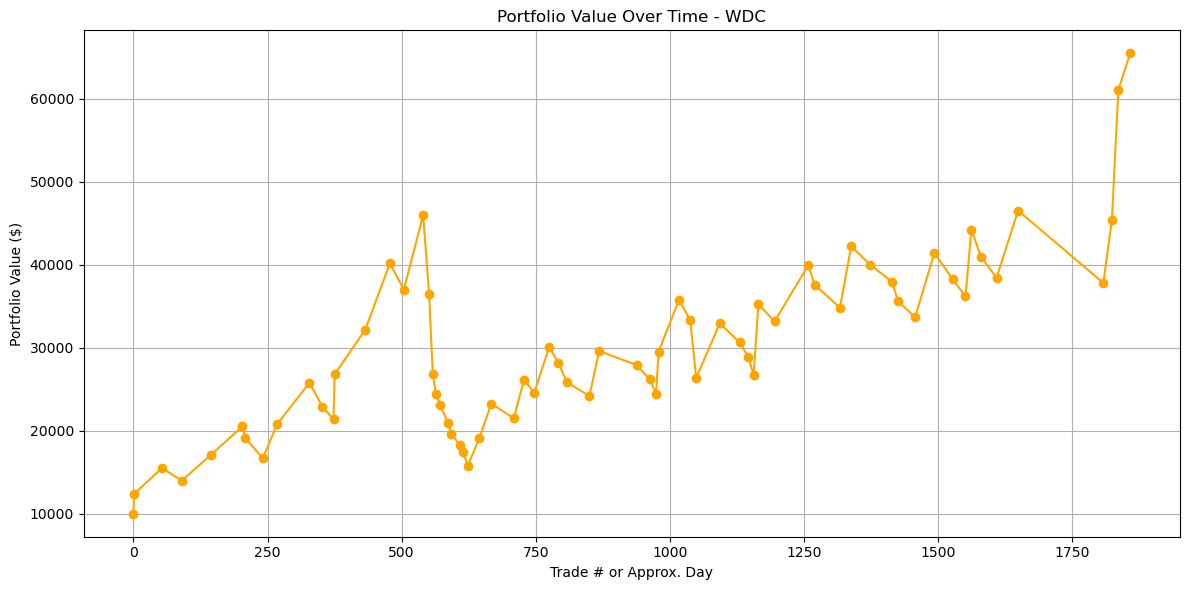

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for TDG...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


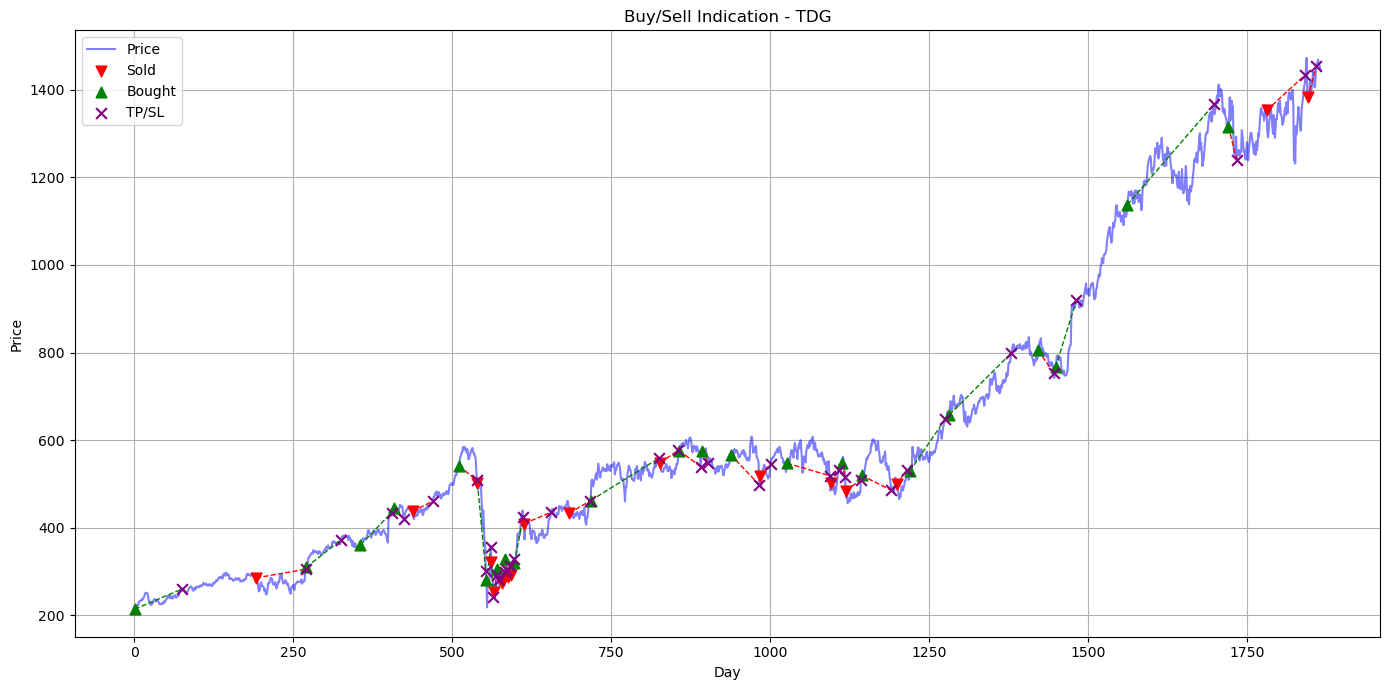


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: 21.27%, Portfolio: $12127.00
Trade 2: Gain: -6.86%, Portfolio: $11295.09
Trade 3: Gain: 20.02%, Portfolio: $13556.36
Trade 4: Gain: 20.53%, Portfolio: $16339.49
Trade 5: Gain: -5.47%, Portfolio: $15445.72
Trade 6: Gain: -5.48%, Portfolio: $14599.29
Trade 7: Gain: -6.04%, Portfolio: $13717.49
Trade 8: Gain: 40.06%, Portfolio: $19212.72
Trade 9: Gain: 27.64%, Portfolio: $24523.12
Trade 10: Gain: 24.92%, Portfolio: $30634.28
Trade 11: Gain: -15.39%, Portfolio: $25919.66
Trade 12: Gain: -8.01%, Portfolio: $23843.50
Trade 13: Gain: -9.39%, Portfolio: $21604.59
Trade 14: Gain: -7.75%, Portfolio: $19930.24
Trade 15: Gain: -8.63%, Portfolio: $18210.26
Trade 16: Gain: -12.45%, Portfolio: $15943.08
Trade 17: Gain: 32.67%, Portfolio: $21151.69
Trade 18: Gain: -6.32%, Portfolio: $19814.90
Trade 19: Gain: -6.45%, Portfolio: $18536.84
Trade 20: Gain: 20.84%, Portfolio: $22399.92
Trade 21: Gain: -5.18%, Portfolio: $21239.60
Trade 22: Gain: -6.3

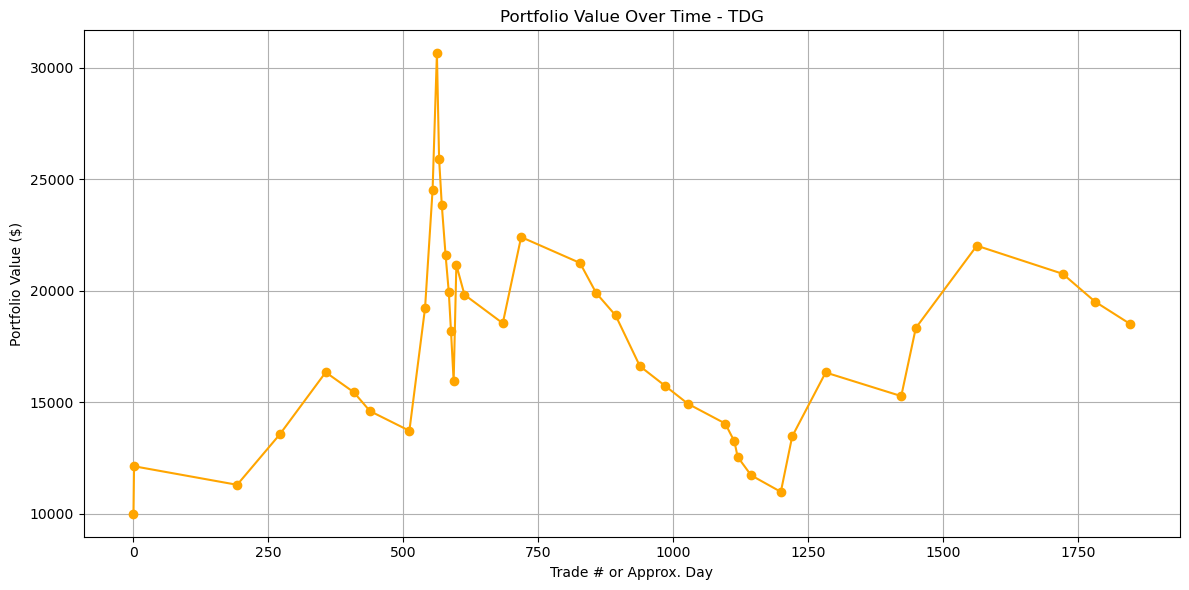

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running strategy for MKTX...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


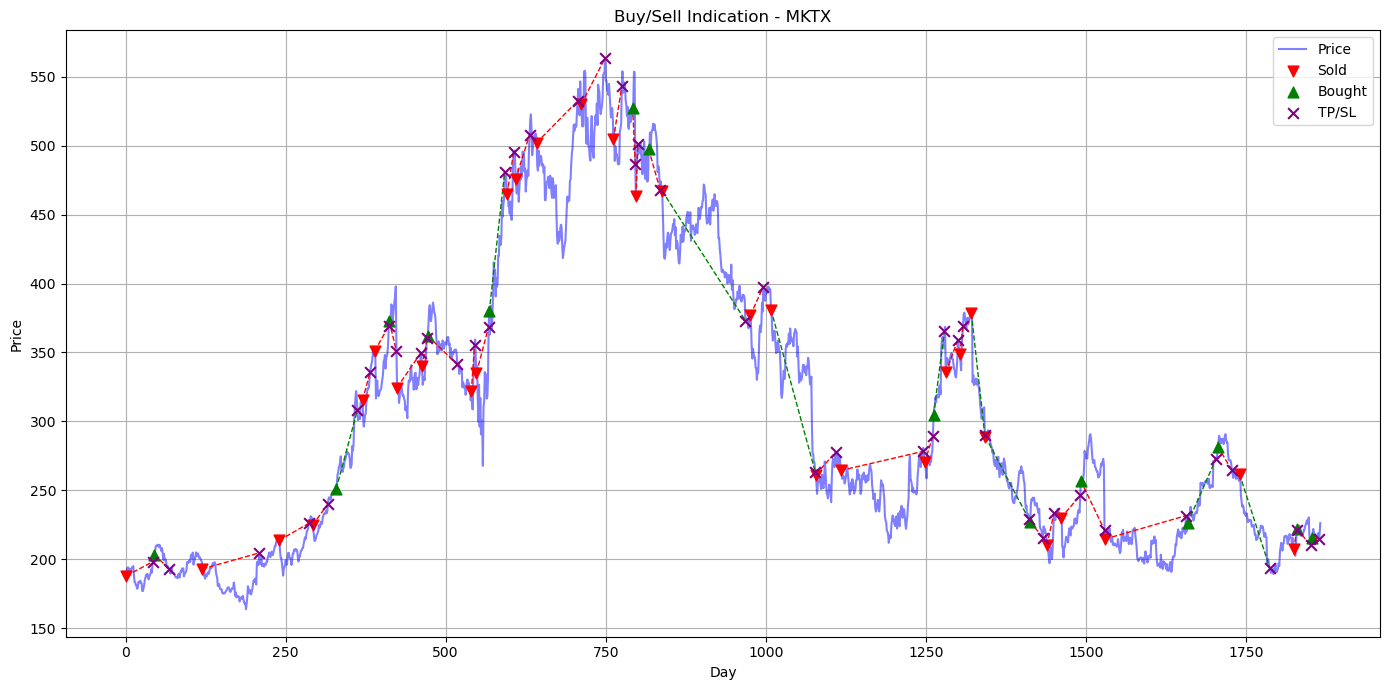


Trade Summary:
Initial Capital: 10000.00
Trade 1: Gain: -5.47%, Portfolio: $9453.00
Trade 2: Gain: -5.02%, Portfolio: $8978.46
Trade 3: Gain: -6.00%, Portfolio: $8439.75
Trade 4: Gain: -5.75%, Portfolio: $7954.47
Trade 5: Gain: -6.87%, Portfolio: $7407.99
Trade 6: Gain: 22.75%, Portfolio: $9093.31
Trade 7: Gain: -6.46%, Portfolio: $8505.88
Trade 8: Gain: -5.22%, Portfolio: $8061.88
Trade 9: Gain: -5.84%, Portfolio: $7591.06
Trade 10: Gain: -7.76%, Portfolio: $7002.00
Trade 11: Gain: -5.96%, Portfolio: $6584.68
Trade 12: Gain: -5.72%, Portfolio: $6208.03
Trade 13: Gain: -10.43%, Portfolio: $5560.54
Trade 14: Gain: -9.92%, Portfolio: $5008.93
Trade 15: Gain: 26.57%, Portfolio: $6339.80
Trade 16: Gain: -6.50%, Portfolio: $5927.72
Trade 17: Gain: -6.84%, Portfolio: $5522.26
Trade 18: Gain: -6.00%, Portfolio: $5190.93
Trade 19: Gain: -6.31%, Portfolio: $4863.38
Trade 20: Gain: -7.58%, Portfolio: $4494.73
Trade 21: Gain: -7.69%, Portfolio: $4149.09
Trade 22: Gain: -8.08%, Portfolio: $3813.8

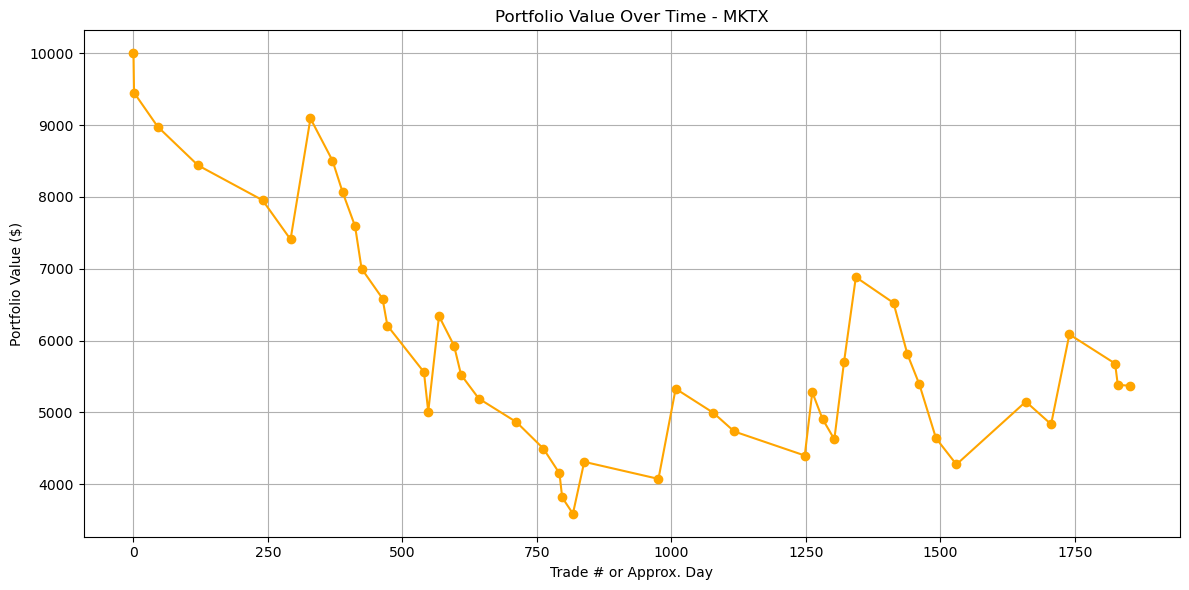

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Total Combined Value: $285533.23

Total Return: 185.53%


In [166]:
diversify(big_tickers_list, '2018-01-01', '2025-06-06', dy, dz, dx, dw, 100000, 10)

## $$Analysis$$

For reasonably stalbe stocks (from S&P500) the strategy returns a healthy profit over a 5 year period.
Now we need to implement some risk analysis then create a trading bot in C++.